# ASME Autodesk Hackathon 2023

### Notebook 3: ML modelling

- __Modelling__: Once the features are ready, they can be used to train a machine learning model. The labels in this case are the material categories.
- __Evaluate__ the predictions of the validation data by calculating the f1 score and showing a confusion matrix

## System Setup

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

# For data standardization (transformation of the data onto unit scale (mean=0 and variance=1), required in most machine learning)
from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
# For data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from pprint import pprint
from scipy.interpolate import griddata
from pylab import * # For adjusting frame width only
from sklearn.preprocessing import OneHotEncoder
import sklearn.gaussian_process as gp 
import sklearn.model_selection as ms
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_digits
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [4]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images")
Feature_PATH = os.path.join(PROJECT_ROOT_DIR, "feature_extraction")
ML_model_PATH = os.path.join(PROJECT_ROOT_DIR, "trained_models")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(Feature_PATH, exist_ok=True)
os.makedirs(ML_model_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [5]:
def show_confusion_matrix(y_true, y_pred, classes=None, classes_categorical=None, normalize=None, figsize=(10, 10), dpi=600, fontsize=10, axis_fontsize=14, tick_size=12):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    
    if normalize == 'true':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.65)
    
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes_categorical, rotation=45, fontsize=tick_size)
        plt.yticks(tick_marks, classes_categorical, fontsize=tick_size)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)
    
    ax.set_xlabel('Predicted label', fontsize=axis_fontsize)
    ax.set_ylabel('True label', fontsize=axis_fontsize)
    # plt.tight_layout()
    # plt.show()

## Import extracted features

In [6]:
feature_dataset = pd.read_csv(os.path.join(Feature_PATH, "feature_transformed_cleaned.csv"))
unnamed_cols = [col for col in feature_dataset.columns if col.startswith('Unnamed')]
df_feature_dataset= feature_dataset.drop(columns=unnamed_cols)

In [7]:
df_feature_dataset.columns

Index(['com_distance', 'center_of_mass_x', 'center_of_mass_y',
       'center_of_mass_z', 'body_area', 'body_volume', 'material_category',
       'volume_fraction', 'bounding_box_max_x', 'bounding_box_max_y',
       ...
       'Toys', 'Utilities & Telecom', 'Virtual Reality', 'Water & Wastewater',
       'Wood Working', 'Civil Infrastructure', 'Engineering & Construction',
       'Media & Entertainment', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object', length=119)

In [8]:
df_feature_dataset

,com_distance,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,volume_fraction,bounding_box_max_x,bounding_box_max_y,...,Toys,Utilities & Telecom,Virtual Reality,Water & Wastewater,Wood Working,Civil Infrastructure,Engineering & Construction,Media & Entertainment,Other Industries,Product Design & Manufacturing
0,0.042693,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
1,0.381353,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,3.355055e-02,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
2,0.774408,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,3.341809e-02,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
3,0.704245,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
4,0.698344,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131229,16.922193,6.132067e-01,0.000000,-2.670490e-11,1.729151,0.116680,Metal_Ferrous_Steel,3.891523e-04,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131230,16.950769,0.000000e+00,0.181651,1.007575e-11,0.129364,0.002853,Metal_Ferrous_Steel,9.514891e-06,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131231,16.961065,-6.182051e-17,-0.011000,8.108617e-12,0.016467,0.000024,Metal_Ferrous_Steel,7.997061e-08,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131232,16.952311,0.000000e+00,0.150000,1.045680e-11,0.109956,0.002356,Metal_Ferrous_Steel,7.858430e-06,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# df_feature_dataset_cleaned = df_feature_dataset.dropna()
df_feature_dataset_cleaned = df_feature_dataset.fillna(df_feature_dataset.median())
df_feature_dataset_cleaned

C:\Users\Asus\AppData\Local\Temp\ipykernel_30904\4194961726.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_feature_dataset_cleaned = df_feature_dataset.fillna(df_feature_dataset.median())


,com_distance,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,volume_fraction,bounding_box_max_x,bounding_box_max_y,...,Toys,Utilities & Telecom,Virtual Reality,Water & Wastewater,Wood Working,Civil Infrastructure,Engineering & Construction,Media & Entertainment,Other Industries,Product Design & Manufacturing
0,0.042693,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
1,0.381353,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,3.355055e-02,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
2,0.774408,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,3.341809e-02,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
3,0.704245,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
4,0.698344,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,2.998711e-01,0.300000,3.200000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131229,16.922193,6.132067e-01,0.000000,-2.670490e-11,1.729151,0.116680,Metal_Ferrous_Steel,3.891523e-04,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131230,16.950769,0.000000e+00,0.181651,1.007575e-11,0.129364,0.002853,Metal_Ferrous_Steel,9.514891e-06,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131231,16.961065,-6.182051e-17,-0.011000,8.108617e-12,0.016467,0.000024,Metal_Ferrous_Steel,7.997061e-08,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1
131232,16.952311,0.000000e+00,0.150000,1.045680e-11,0.109956,0.002356,Metal_Ferrous_Steel,7.858430e-06,5.662714,4.830419,...,0,0,0,0,0,0,0,0,0,1


## Constructing labels and input features for training the models

In [10]:
df_feature_dataset_cleaned['Material Category (Target)']

0         5
1         2
2         3
3         4
4         5
         ..
131229    2
131230    2
131231    2
131232    2
131233    2
Name: Material Category (Target), Length: 131234, dtype: int64

In [11]:
df_feature_dataset_cleaned["material_category"]

0                     Plastic
1         Metal_Ferrous_Steel
2           Metal_Non-Ferrous
3                       Other
4                     Plastic
                 ...         
131229    Metal_Ferrous_Steel
131230    Metal_Ferrous_Steel
131231    Metal_Ferrous_Steel
131232    Metal_Ferrous_Steel
131233    Metal_Ferrous_Steel
Name: material_category, Length: 131234, dtype: object

In [12]:
Label = df_feature_dataset_cleaned['material_category'].to_list()
label_numeric = df_feature_dataset_cleaned['Material Category (Target)'].to_list()
y = df_feature_dataset_cleaned['Material Category (Target)'].to_list()
X = df_feature_dataset_cleaned.drop(columns=['Material Category (Target)', 'material_category']).to_numpy()

In [13]:
print (X)

[[ 4.26927310e-02  9.17059266e-16  2.84628582e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 3.81352889e-01 -2.05790525e-09  2.42325804e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 7.74407959e-01 -2.06606205e-09  2.42140423e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 ...
 [ 1.69610651e+01 -6.18205115e-17 -1.10000000e-02 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.69523111e+01  0.00000000e+00  1.50000000e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.69445259e+01  3.45112270e-17  3.25000000e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


## Split the *train* set into *train* and *validation*

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, 
                                                  stratify = df_feature_dataset_cleaned.material_category, shuffle=True)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

le = LabelEncoder()

le.fit_transform(y)
Y_train = le.transform(y_train)
Y_val = le.transform(y_val)

Training set size: 104987
Validation set size: 26247


In [15]:
X_train

array([[ 7.06533886e+00, -6.96143238e-13,  1.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 6.43652266e+00,  2.69085536e+00,  7.42219714e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 5.30591110e+03,  4.14654594e+02,  3.24999251e+04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.33561963e+01, -1.45055344e+01,  6.80296445e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 2.68211942e+00,  3.56074953e-01,  2.43982138e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 2.34019001e+01,  4.27540995e+01, -2.66343029e+01, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [16]:
le.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [17]:
Y_train

array([3, 2, 4, ..., 4, 2, 0], dtype=int64)

In [18]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

### Compute class weight

This is for treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only).

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

print(f"class weights: {class_weights}")
print(f"class        : {np.unique(le.classes_)}")

class weights: [1.77031903 2.60294045 0.47026441 1.15503603 0.66487024 0.93487146
 2.06188381]
class        : [0 1 2 3 4 5 6]


### Data standarization

In [20]:
scaler = preprocessing.StandardScaler() 

X_train_transformed = scaler.fit_transform(X_train)
X_val_transformed = scaler.transform(X_val)

# ML model training

Predicts the __material category__ based on selected features, iterating over the algorithms:

- K nearest neighbor classification: 'KNN'

- Decision Tree classification: 'DT'

- Adaptive Boosting classification: 'AdaBoost'

- Random Forests classification 'RF'

- Gaussian Process classification 'GPR'

- Support Vector classification 'SVR'

- Gradient Boosting classification 'GB'

- Nerual Network classification 'NN'

## Step1: Hyperparameter tuning: RandomizedSearchCV

- Considering the feature space and the data volume, RandomizedSearchCV is much more faster to do.
- Get a initial result for hyperparameter values

### Parameter Distributions:

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import numpy as np

# For KNN:
knn_distributions = {
    'n_neighbors': sp_randint(1, 50),
    'weights': ['uniform', 'distance']
}
knn_search = RandomizedSearchCV(neighbors.KNeighborsClassifier(), knn_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For Decision Trees:
dt_distributions = {
    'min_samples_split': sp_randint(2, 20),
    'max_depth': sp_randint(1, 50)
}
dt_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), dt_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For Logistic Regression:
lr_distributions = {
    'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': uniform(0.01, 10),
    'max_iter': sp_randint(100, 1000)
}
lr_search = RandomizedSearchCV(LogisticRegression(), lr_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For AdaBoost:
ada_distributions = {
    'n_estimators': sp_randint(1, 500),
    'algorithm': ['SAMME', 'SAMME.R']
}
ada_search = RandomizedSearchCV(AdaBoostClassifier(), ada_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For Random Forest:
rf_distributions = {
    'n_estimators': sp_randint(1, 500),
    'min_samples_split': sp_randint(2, 20),
    'max_depth': sp_randint(1, 50)
}
rf_search = RandomizedSearchCV(RandomForestClassifier(), rf_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For Gaussian Process:
gp_distributions = {
    'kernel': [gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))]
}
gp_search = RandomizedSearchCV(gp.GaussianProcessClassifier(), gp_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)

# For Neural Network:
nn_distributions = {
    'hidden_layer_sizes': [(sp_randint(16, 256).rvs(), sp_randint(16, 256).rvs(), sp_randint(16, 256).rvs()) for _ in range(10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': uniform(0.001, 0.1),
    'learning_rate': ['adaptive'],
    'max_iter': sp_randint(1000, 20000)
}
nn_search = RandomizedSearchCV(MLPClassifier(), nn_distributions, n_iter=10, scoring="accuracy", cv=5, n_jobs=-1, verbose=3, random_state=42)


### RandomizedSearchCV Initialization & Model Fitting:

In [22]:
n_iter_search = 10

# KNN
knn_search.fit(X_train, y_train)

# Decision Tree
dt_search.fit(X_train, y_train)

# Logistic Regression:
lr_search.fit(X_train, y_train)

# AdaBoost
ada_search.fit(X_train, y_train)

# Random Forest
rf_search.fit(X_train, y_train)

# Gaussian Process
# gp_search.fit(X_train, y_train)

# Neural Network:
# nn_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FC08A84190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FC08A8E7C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FC08A8EDC0>},
                   random_state=42, scoring='accuracy', verbose=3)

In [23]:
print("Best parameters for KNN: ", knn_search.best_params_)
print("Best cross-validation score for KNN: {:.2f}".format(knn_search.best_score_))

print("Best parameters for DT: ", dt_search.best_params_)
print("Best cross-validation score for DT: {:.2f}".format(dt_search.best_score_))

print("Best parameters for LR: ", lr_search.best_params_)
print("Best cross-validation score for LR: {:.2f}".format(lr_search.best_score_))

print("Best parameters for Ada: ", ada_search.best_params_)
print("Best cross-validation score for Ada: {:.2f}".format(ada_search.best_score_))

print("Best parameters for RF: ", rf_search.best_params_)
print("Best cross-validation score for RF: {:.2f}".format(rf_search.best_score_))

# print("Best parameters for GP: ", gp_search.best_params_)
# print("Best cross-validation score for GP: {:.2f}".format(gp_search.best_score_))

# print("Best parameters for NN: ", nn_search.best_params_)
# print("Best cross-validation score for NN: {:.2f}".format(nn_search.best_score_))

Best parameters for KNN:  {'n_neighbors': 11, 'weights': 'uniform'}
Best cross-validation score for KNN: 0.69
Best parameters for DT:  {'max_depth': 40, 'min_samples_split': 4}
Best cross-validation score for DT: 0.78
Best parameters for LR:  {'C': 3.7554011884736247, 'max_iter': 960, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score for LR: 0.08
Best parameters for Ada:  {'algorithm': 'SAMME.R', 'n_estimators': 373}
Best cross-validation score for Ada: 0.41
Best parameters for RF:  {'max_depth': 38, 'min_samples_split': 3, 'n_estimators': 192}
Best cross-validation score for RF: 0.83


### Step 2: Train the model using the best hyperparameter on the trianing dataset

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=11, weights='uniform')
knn_model.fit(X_train_transformed, y_train)
knn_val_score = knn_model.score(X_val_transformed, y_val)
print(f"Validation score for KNN: {knn_val_score:.2f}")

# Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=40, min_samples_split=4)
dt_model.fit(X_train_transformed, y_train)
dt_val_score = dt_model.score(X_val_transformed, y_val)
print(f"Validation score for DT: {dt_val_score:.2f}")

# Logistic Regression Model
lr_model = LogisticRegression(C=3.7554011884736247, max_iter=960, penalty='l2', solver='lbfgs')
lr_model.fit(X_train_transformed, y_train)
lr_val_score = lr_model.score(X_val_transformed, y_val)
print(f"Validation score for LR: {lr_val_score:.2f}")

# AdaBoost Model
ada_model = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=373)
ada_model.fit(X_train_transformed, y_train)
ada_val_score = ada_model.score(X_val_transformed, y_val)
print(f"Validation score for AdaBoost: {ada_val_score:.2f}")

# RandomForest Model
rf_model = RandomForestClassifier(max_depth=38, min_samples_split=3, n_estimators=192)
rf_model.fit(X_train_transformed, y_train)
rf_val_score = rf_model.score(X_val_transformed, y_val)
print(f"Validation score for RandomForest: {rf_val_score:.2f}")

Validation score for KNN: 0.69
Validation score for DT: 0.77


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation score for LR: 0.37
Validation score for AdaBoost: 0.40
Validation score for RandomForest: 0.85


## Grid Search CV

In [25]:
###########-----------------------KNN---------------------######################
tuned_parameters = {'n_neighbors': [5, 10,20,50],
                    'weights': ['uniform', 'distance']}    
score = "accuracy" 
metamodel_KNN = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, n_jobs=2, verbose=4, scoring=score, cv=5)

###########-----------------------DT---------------------######################
tuned_parameters = {'min_samples_split': [5, 10, 20],
                    'max_depth': [5, 10, 20, 30]}    

metamodel_DT = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------LR---------------------######################
tuned_parameters = {'solver': ['lbfgs'],
                    'penalty' : ['l2'],
                    'C' : [0.01, 0.1, 1, 10], 
                    'max_iter': [1000]}    # a dict (dictionary)
metamodel_LR = GridSearchCV(LogisticRegression(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------NB---------------------######################
tuned_parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}    # a dict (dictionary)
metamodel_NB = GridSearchCV(GaussianNB(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------Adaboost---------------------######################
tuned_parameters = {'n_estimators':[10, 50, 100, 200],
                    'algorithm': ['SAMME', 'SAMME.R']}    # a dict (dictionary)

metamodel_AdaBoost = GridSearchCV(AdaBoostClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------RF---------------------######################
tuned_parameters = {'n_estimators': [10, 50, 100, 200],
                    'min_samples_split': [2, 5, 10],
                    'max_depth': [5, 10, 20, 30]}    # a dict (dictionary)
# score = "r2" 
metamodel_RF = GridSearchCV(RandomForestClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)
    
    
###########-----------------------SVC---------------------######################
tuned_parameters = {'gamma': [1e-3, 1e-4],
                    'C': [0.1, 1, 10, 100]}    # a dict (dictionary)

metamodel_SVC = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=1, verbose=3, scoring=score, cv=5)

    
###########-----------------------GB---------------------######################
tuned_parameters = {'n_estimators': [10, 50, 100, 200]}    # a dict (dictionary)

metamodel_GB = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, n_jobs=1,verbose=3, scoring=score, cv=5)

    
###########-----------------------GP---------------------######################
# kernal optimization
tuned_parameters = {
                    # 'kernel': [1*gp.kernels.RBF(), 1*gp.kernels.DotProduct(), 
                    #            1*gp.kernels.Matern(),  1*gp.kernels.RationalQuadratic(),
                    #            1*gp.kernels.WhiteKernel(), 
                    #            gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    'kernel': [gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    # 'n_restarts_optimizer': [10],
                    # 'alpha': [1e-4, 1e-3],
                    # 'normalize_y': [True],
                   }    

metamodel_GP = GridSearchCV(gp.GaussianProcessClassifier(), tuned_parameters, n_jobs=1,verbose=3, scoring=score, cv=5)


###########-----------------------NN---------------------######################
tuned_parameters = {'hidden_layer_sizes': [ (32, 64, 128, 64), 
                                            (16, 32, 256, 32 ), 
                                            (16, 32, 256, 128)],
                    'activation': ['relu'],
                    'solver': ['adam'],
                    'alpha': [0.1, 0.01], 
                    'learning_rate': ['adaptive'],
                    'max_iter':[20000]}

metamodel_NN = GridSearchCV(MLPClassifier(), tuned_parameters, n_jobs=1, verbose=3, scoring=score, cv=5)

In [26]:
metamodel_KNN.fit(X_train, y_train)
print ("KNN finished")
metamodel_DT.fit(X_train, y_train)
print ("DT finished")
# metamodel_AdaBoost.fit(X_all_train_transformed, Y_all_train)
# print ("AdaBoost finished")
# metamodel_NB.fit(X_all_train_transformed, Y_all_train)
# print ("NB finished")
metamodel_LR.fit(X_train, y_train)
print ("LR finished")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNN finished
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..max_depth=5, min_samples_split=5;, score=0.370 total time=   1.3s
[CV 2/5] END ..max_depth=5, min_samples_split=5;, score=0.376 total time=   1.2s
[CV 3/5] END ..max_depth=5, min_samples_split=5;, score=0.381 total time=   1.3s
[CV 4/5] END ..max_depth=5, min_samples_split=5;, score=0.373 total time=   1.3s
[CV 5/5] END ..max_depth=5, min_samples_split=5;, score=0.373 total time=   1.3s
[CV 1/5] END .max_depth=5, min_samples_split=10;, score=0.370 total time=   1.3s
[CV 2/5] END .max_depth=5, min_samples_split=10;, score=0.376 total time=   1.3s
[CV 3/5] END .max_depth=5, min_samples_split=10;, score=0.381 total time=   1.2s
[CV 4/5] END .max_depth=5, min_samples_split=10;, score=0.373 total time=   1.2s
[CV 5/5] END .max_depth=5, min_samples_split=10;, score=0.373 total time=   1.2s
[CV 1/5] END .max_depth=5, min_samples_split=20;, score=

C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 2/5] END C=0.01, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 4/5] END C=0.01, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s
[CV 1/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 2/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s
[CV 3/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 4/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s
[CV 5/5] END C=1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 1/5] END C=10, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 2/5] END C=10, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 3/5] END C=10, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 4/5] END C=10, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 5/5] END C=10, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.1s
LR finished


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
metamodel_RF.fit(X_train, y_train)
print ("RF finished")
metamodel_SVC.fit(X_train, y_train)
print ("SVC finished")
# metamodel_GB.fit(X_train, y_train)
# print ("GB finished")
# metamodel_GP.fit(X_train, y_train)
# print ("GPC finished")
# metamodel_NN.fit(X_train, y_train)
# print ("NN finished")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=5, min_samples_split=2, n_estimators=10;, score=0.380 total time=   0.1s
[CV 2/5] END max_depth=5, min_samples_split=2, n_estimators=10;, score=0.373 total time=   0.1s
[CV 3/5] END max_depth=5, min_samples_split=2, n_estimators=10;, score=0.377 total time=   0.1s
[CV 4/5] END max_depth=5, min_samples_split=2, n_estimators=10;, score=0.384 total time=   0.1s
[CV 5/5] END max_depth=5, min_samples_split=2, n_estimators=10;, score=0.373 total time=   0.1s
[CV 1/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.381 total time=   0.3s
[CV 2/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.384 total time=   0.3s
[CV 3/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.385 total time=   0.3s
[CV 4/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.376 total time=   0.3s
[CV 5/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.3

KeyboardInterrupt: 

### Best hyperparameters of each models

In [28]:
print("\n KNN Best parameters set found on development set:")
print(metamodel_KNN.best_params_)
print("\n DT Best parameters set found on development set:")
print(metamodel_DT.best_params_)
# print("\n AdaBoostBest parameters set found on development set:")
# print(metamodel_AdaBoost.best_params_)
# print("\n NB Best parameters set found on development set:")
# print(metamodel_NB.best_params_)
print("\n LR Best parameters set found on development set:")
print(metamodel_LR.best_params_)
# print("\n RF Best parameters set found on development set:")
# print(metamodel_RF.best_params_)
# print("\n SVC Best parameters set found on development set:")
# print(metamodel_SVC.best_params_)
# print("\n GB Best parameters set found on development set:")
# print(metamodel_GB.best_params_)
# print("\n GP Best parameters set found on development set:")
# print(metamodel_GP.best_params_)
# print("\n NN Best parameters set found on development set:")
# print(metamodel_NN.best_params_)


 KNN Best parameters set found on development set:
{'n_neighbors': 5, 'weights': 'uniform'}

 DT Best parameters set found on development set:
{'max_depth': 30, 'min_samples_split': 5}

 LR Best parameters set found on development set:
{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


## Make predictions for all bodies in the validation assemblies

In [29]:
accuracy_mean_list = []
accuracy_std_list = []

auc_mean_list = []
auc_std_list = []

              precision    recall  f1-score   support

           0       0.60      0.59      0.59      2118
           1       0.68      0.72      0.70      1440
           2       0.69      0.77      0.73      7973
           3       0.67      0.63      0.65      3247
           4       0.71      0.68      0.69      5640
           5       0.70      0.62      0.66      4011
           6       0.78      0.70      0.73      1818

    accuracy                           0.69     26247
   macro avg       0.69      0.67      0.68     26247
weighted avg       0.69      0.69      0.69     26247

Saving figure confusion_matrix_basic_feature_KNN
Test Accuracy (cross-validation) for KNN = 0.68873 ± 0.00510
micro-averaging AUC for KNN = 0.93413 ± 0.00000
Saving figure ROC_KNN_basic_feature
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      2118
           1       0.80      0.81      0.80      1440
           2       0.77      0.80      0.78   

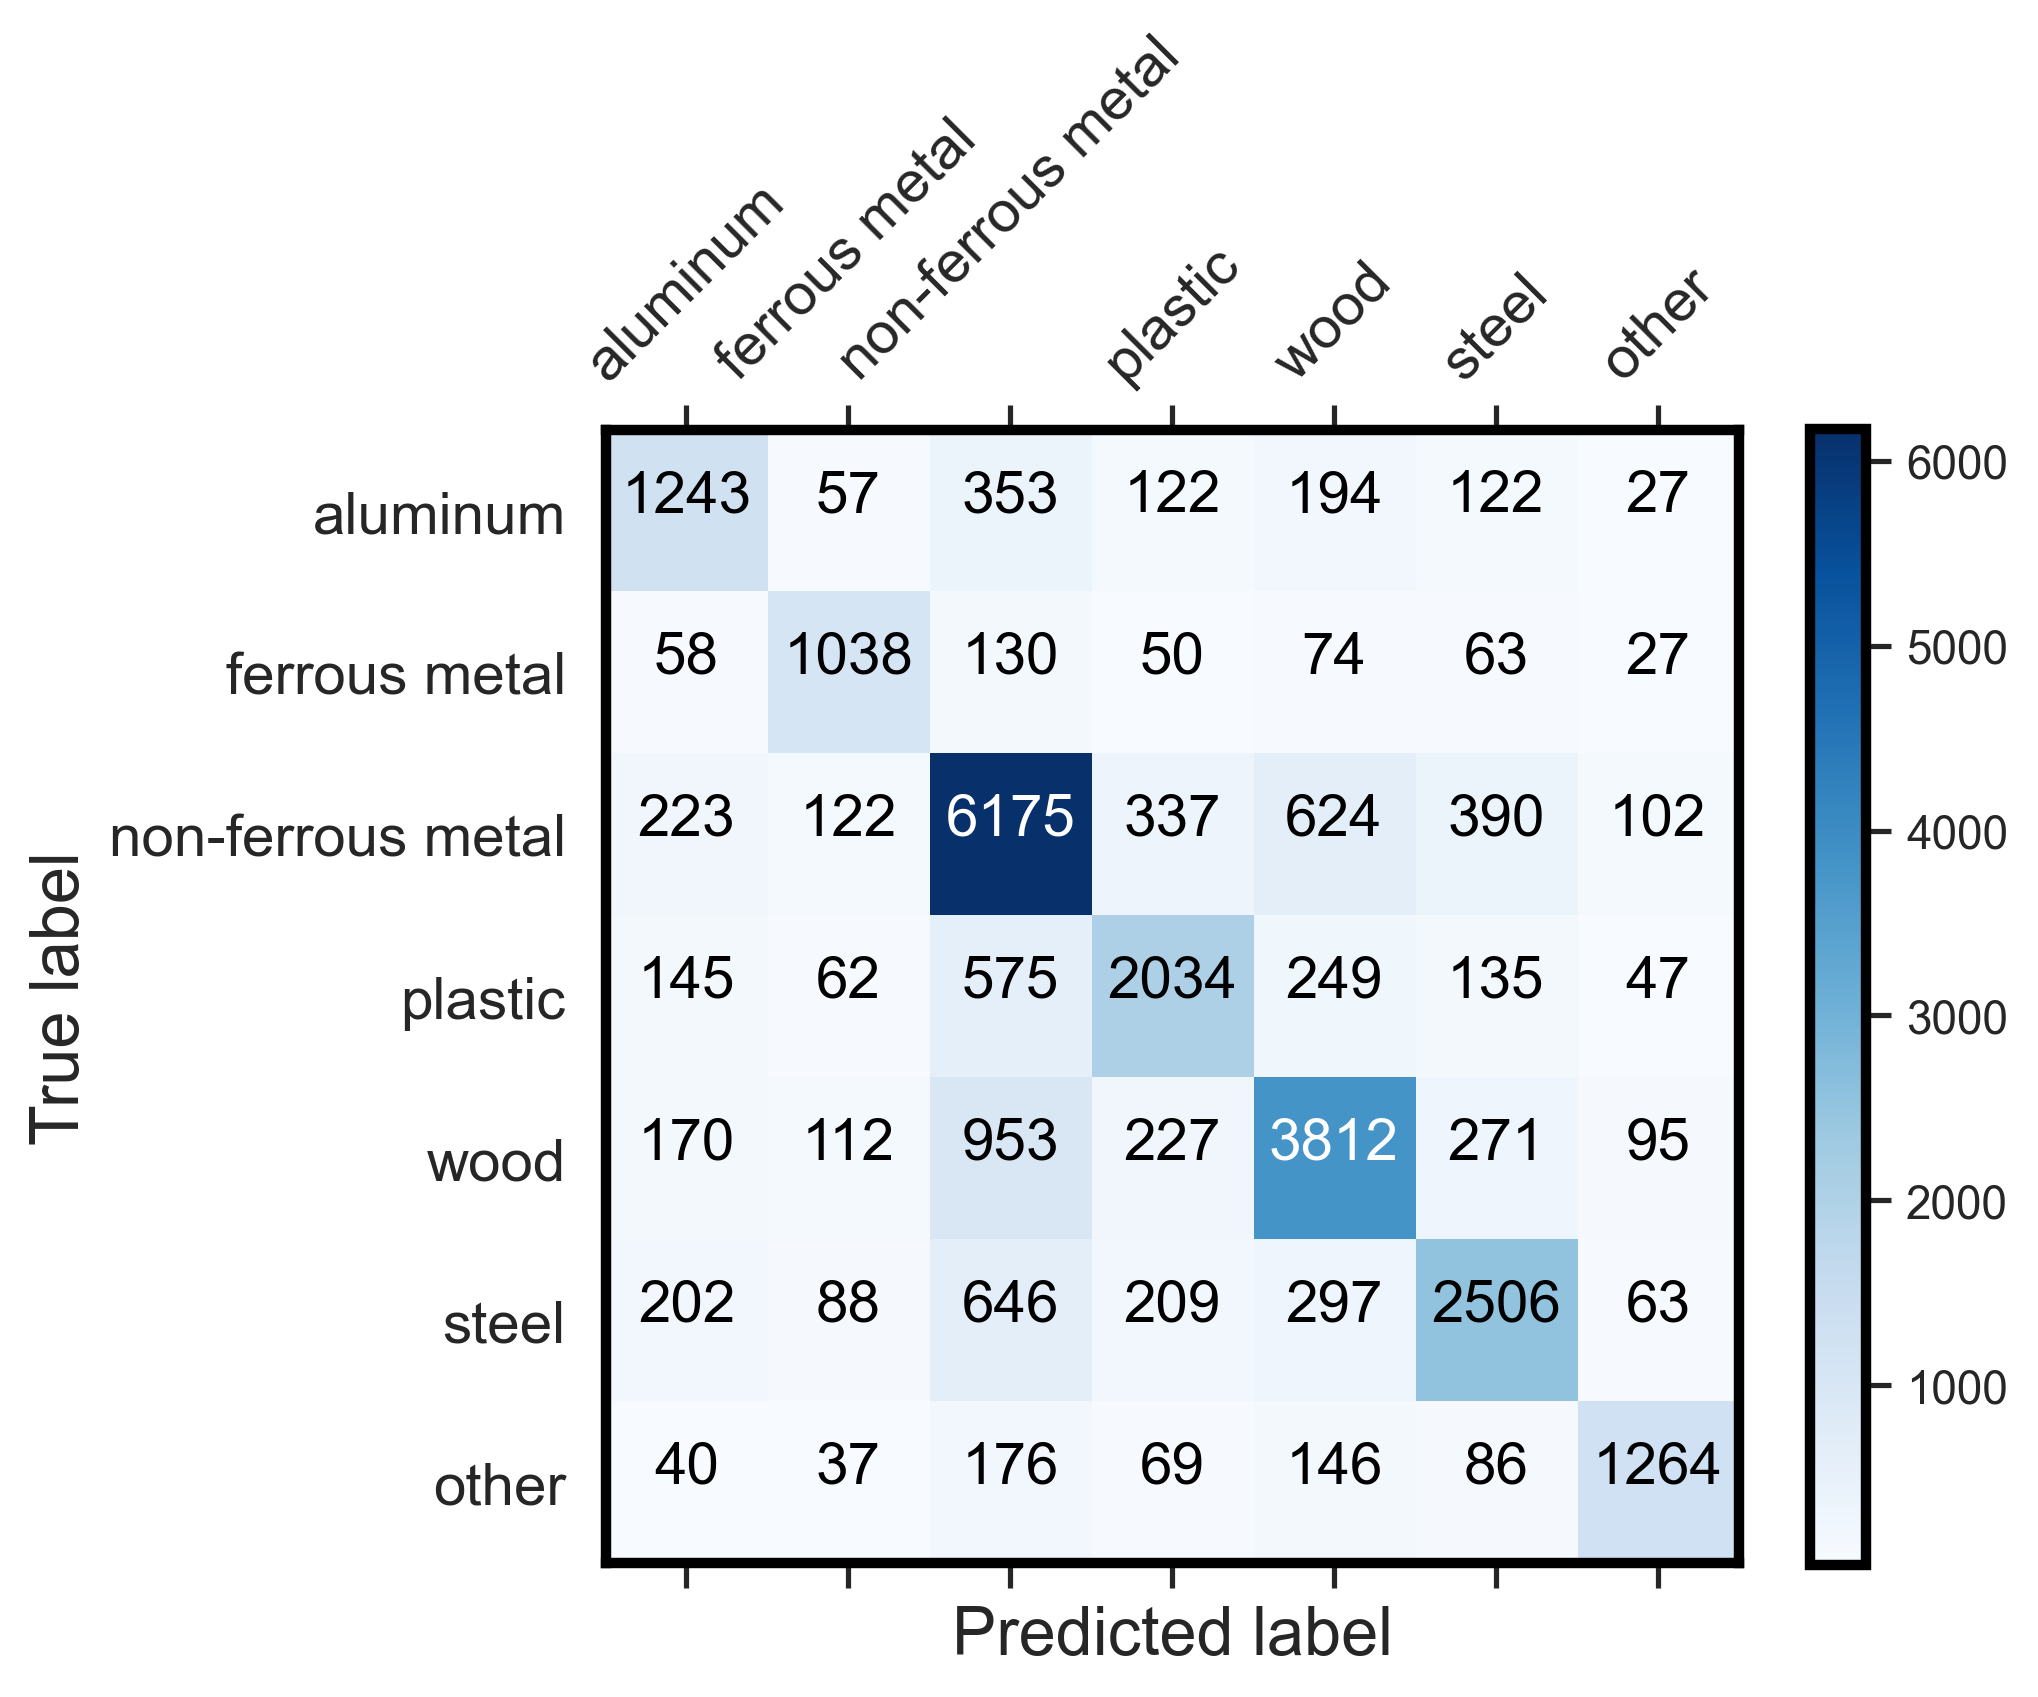

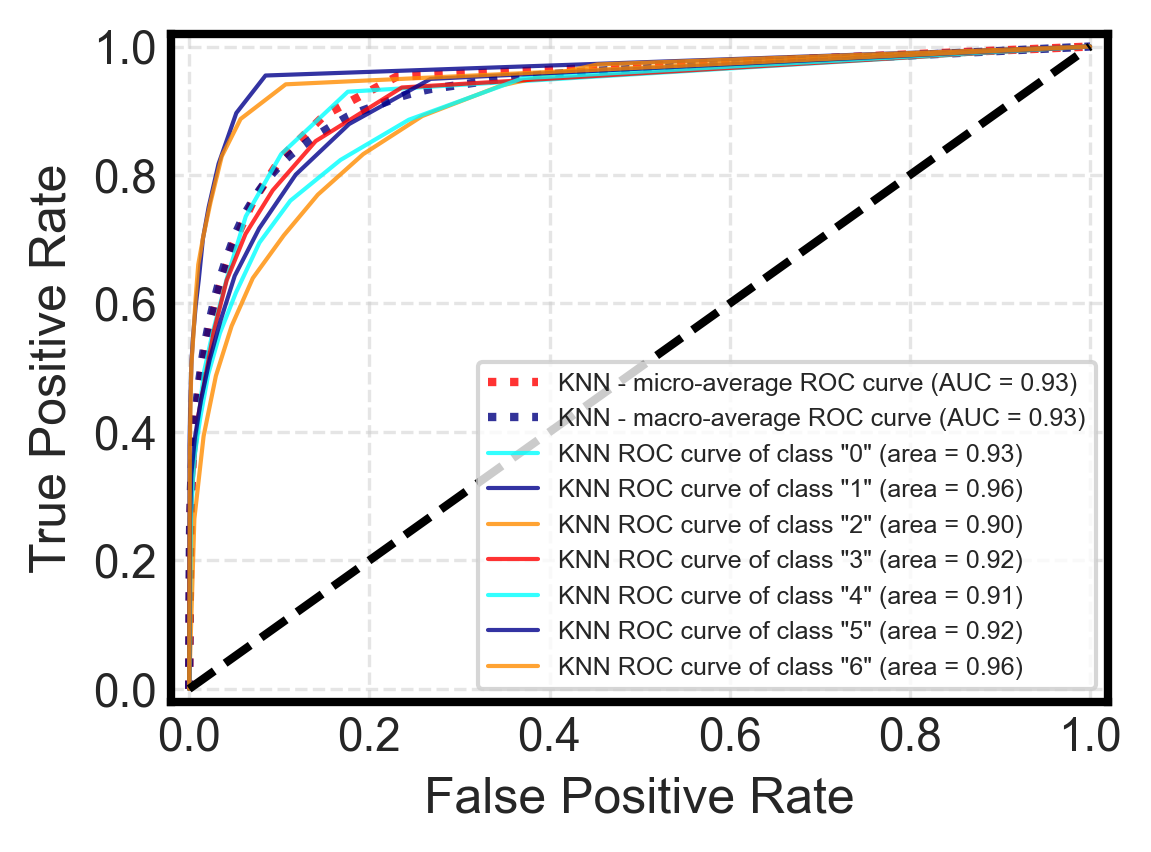

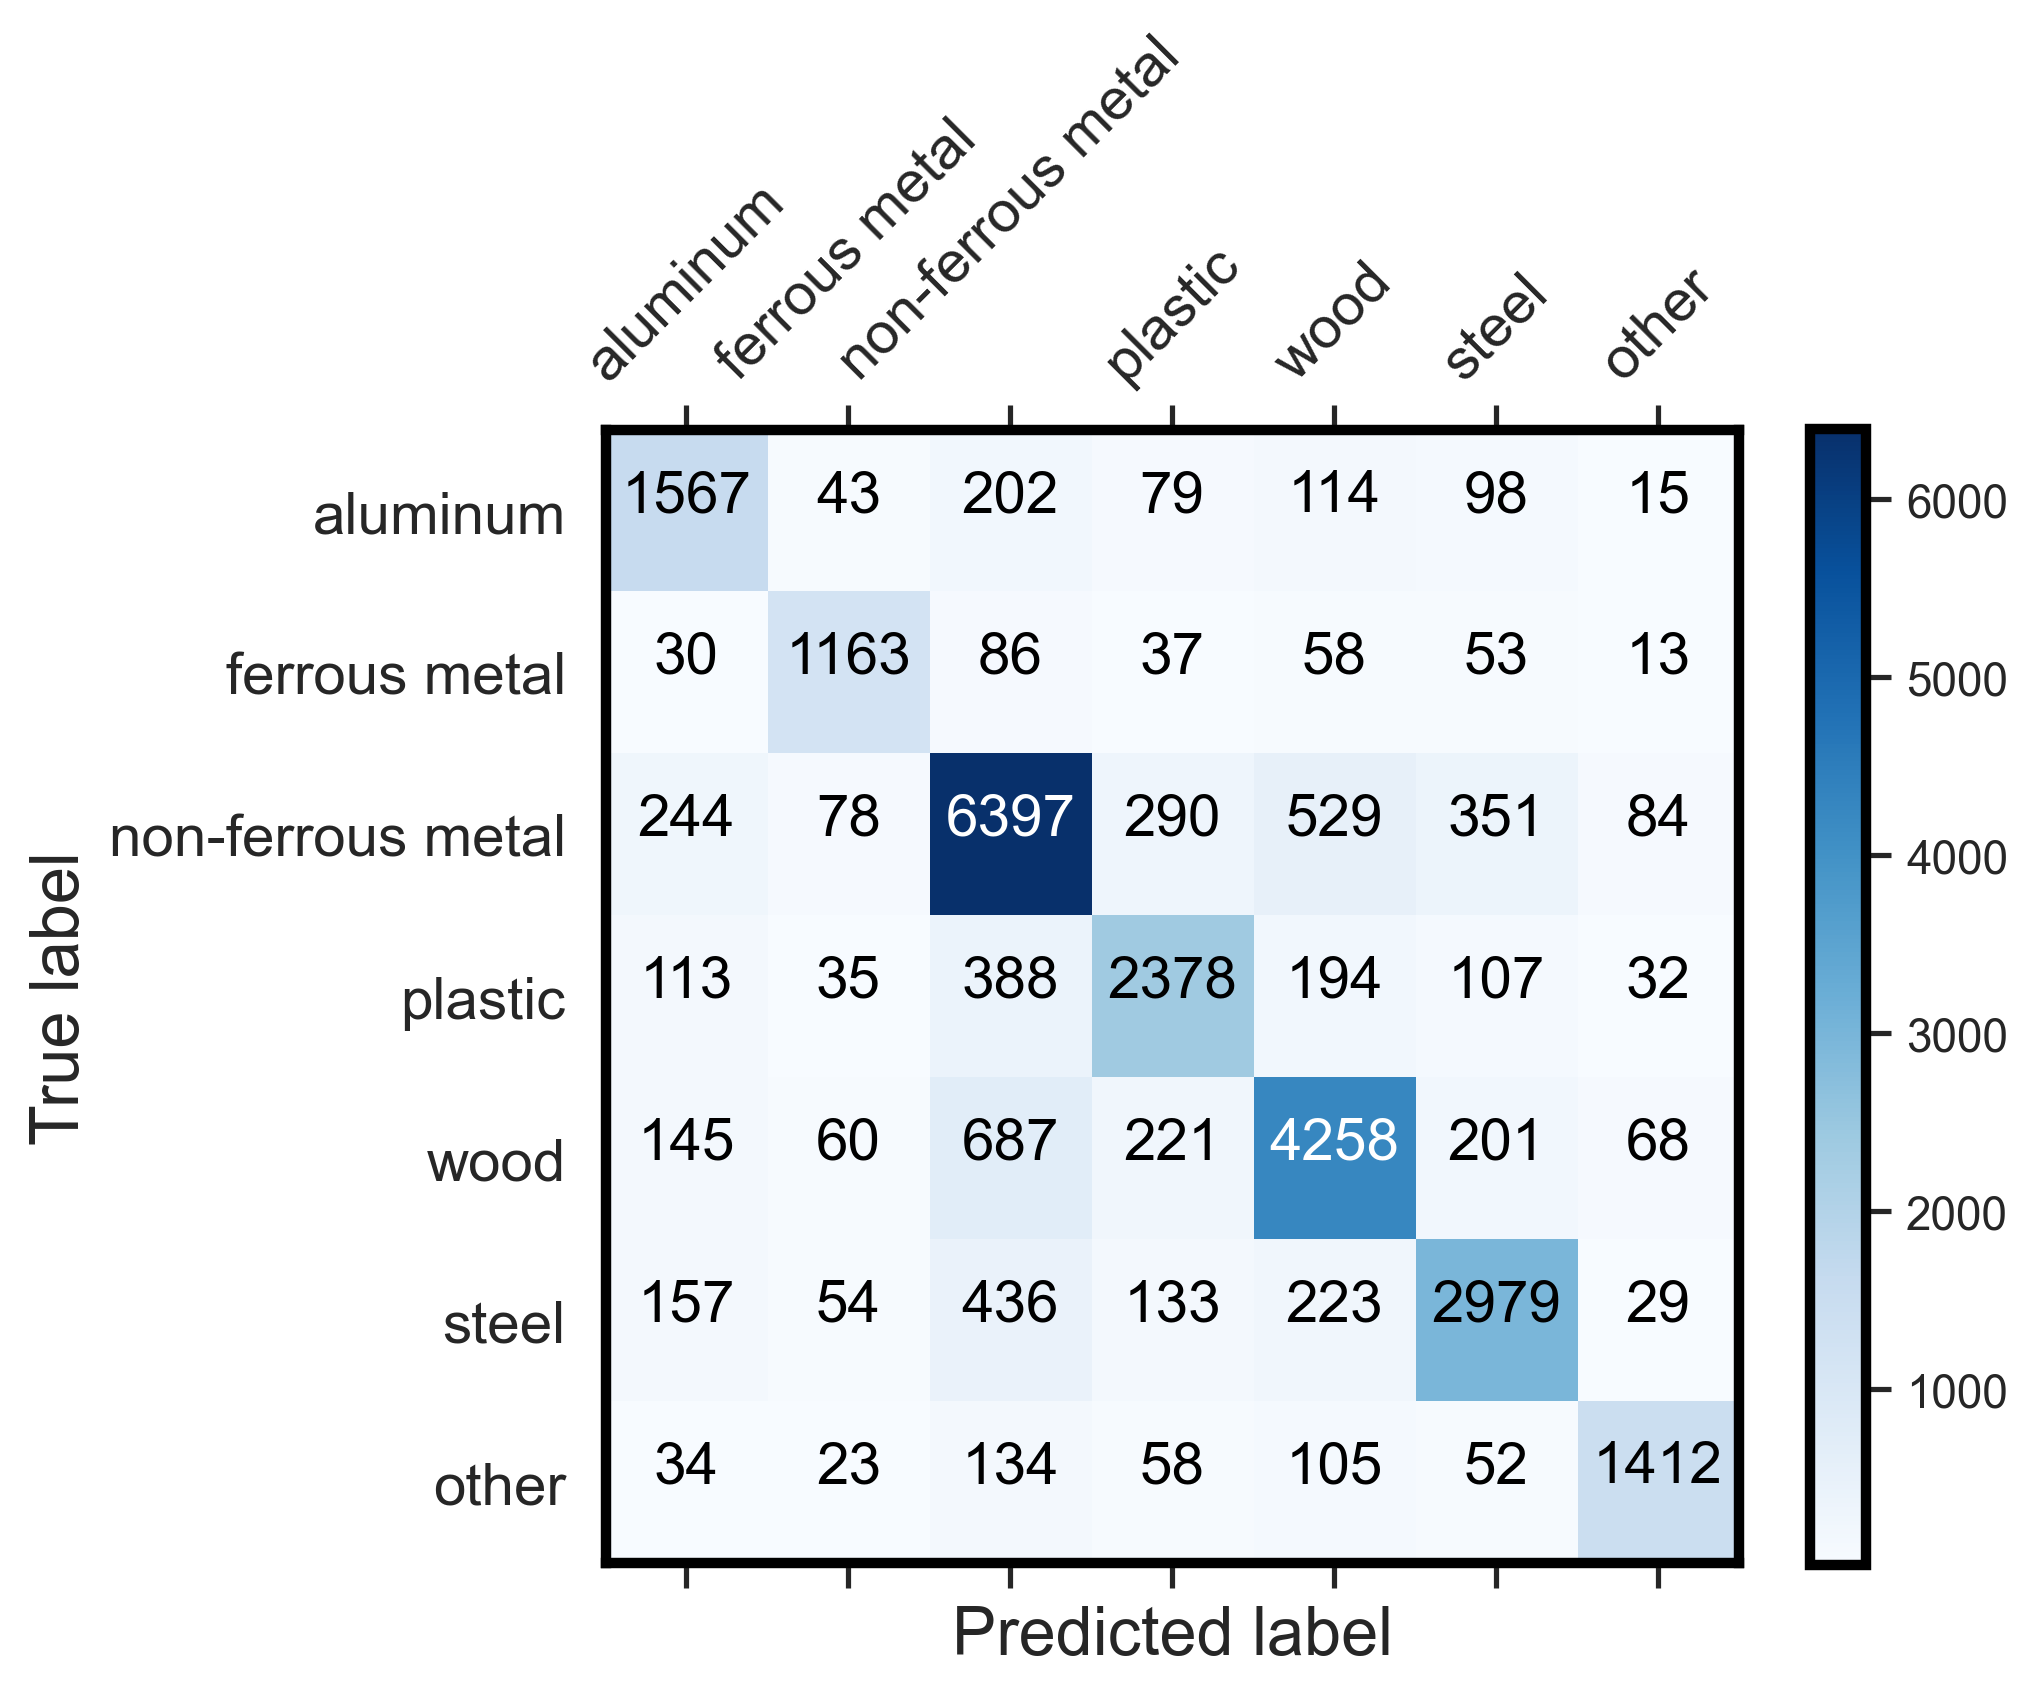

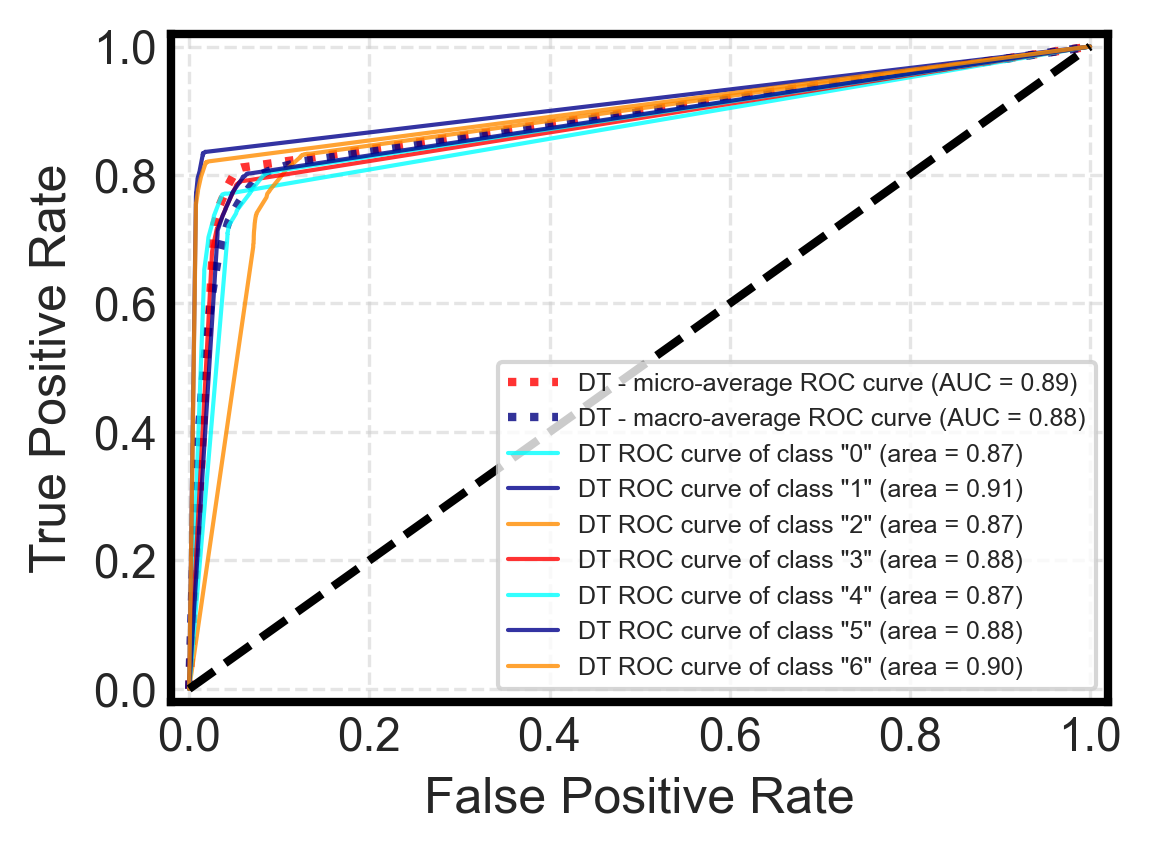

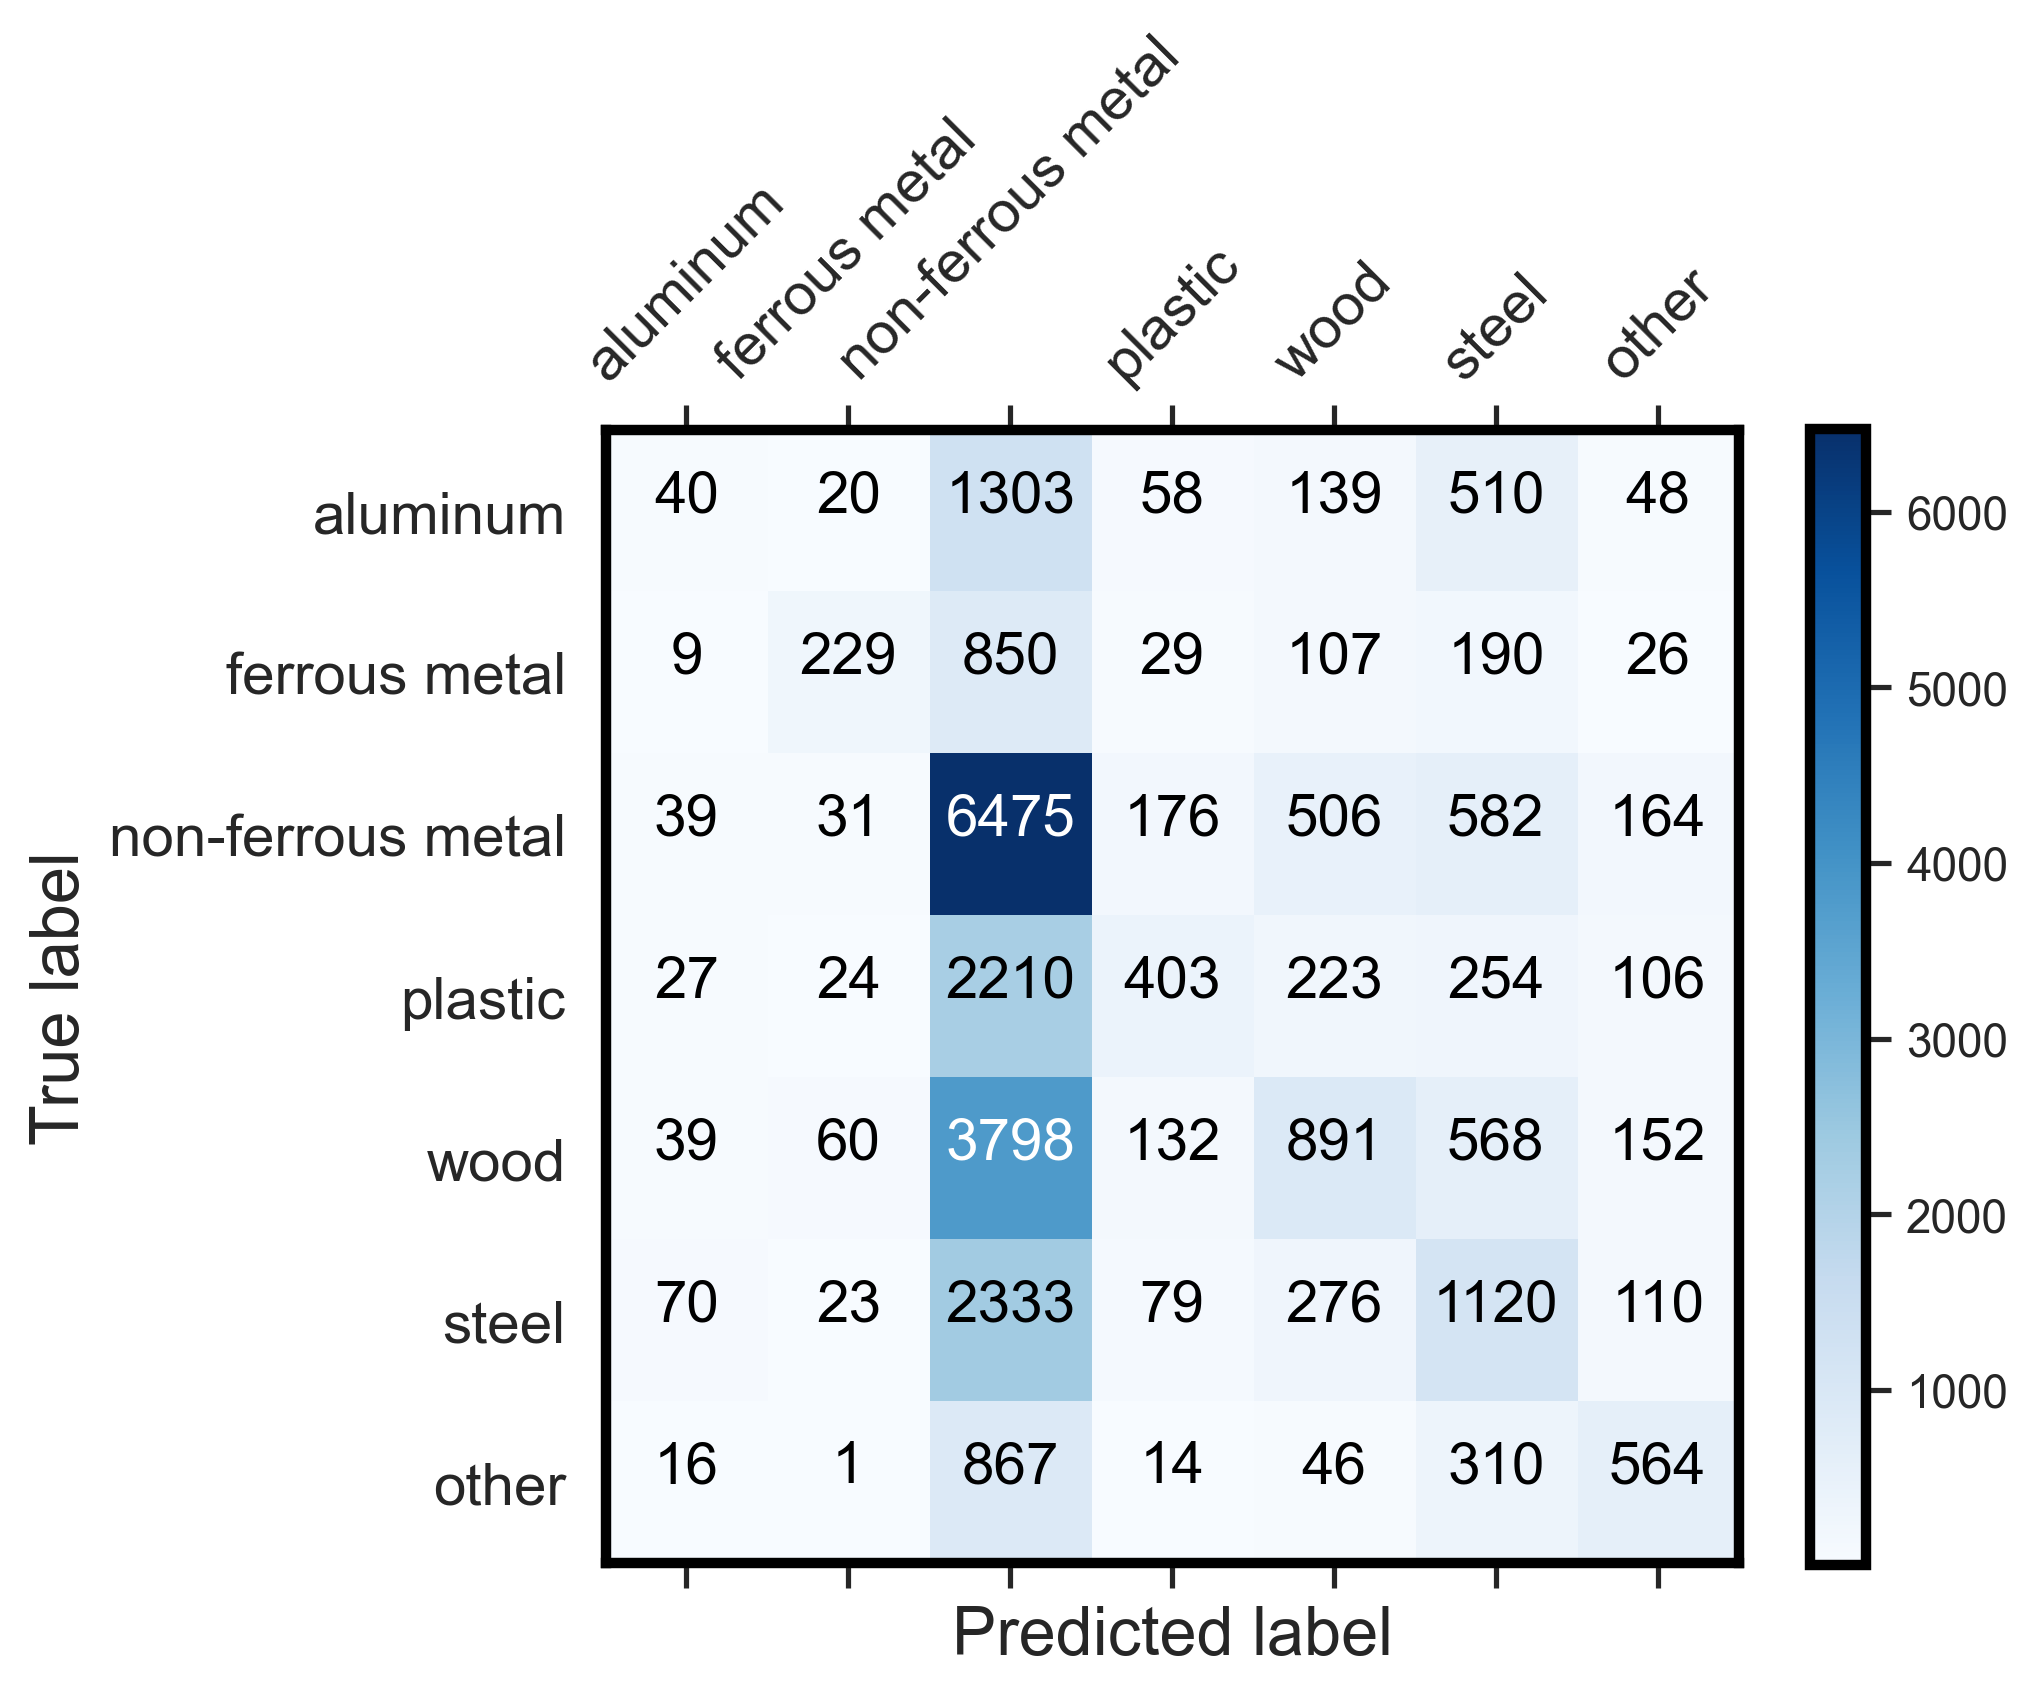

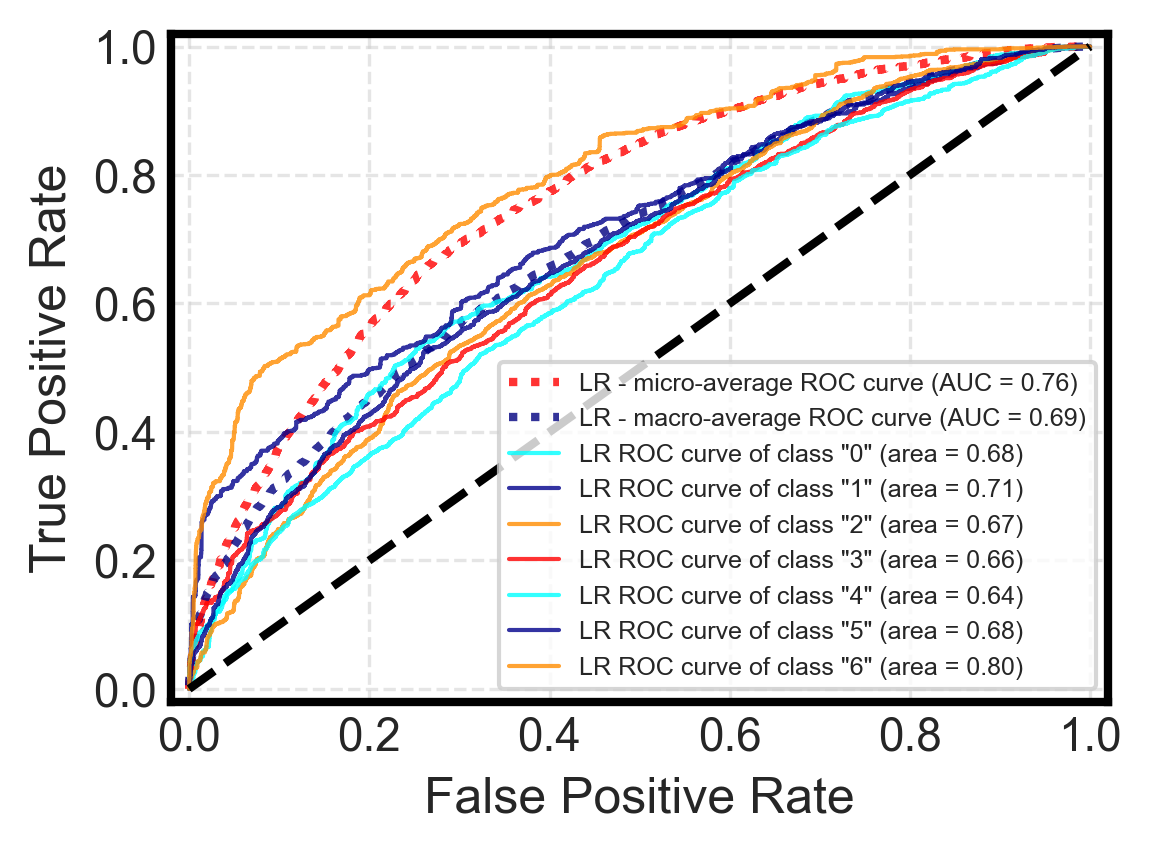

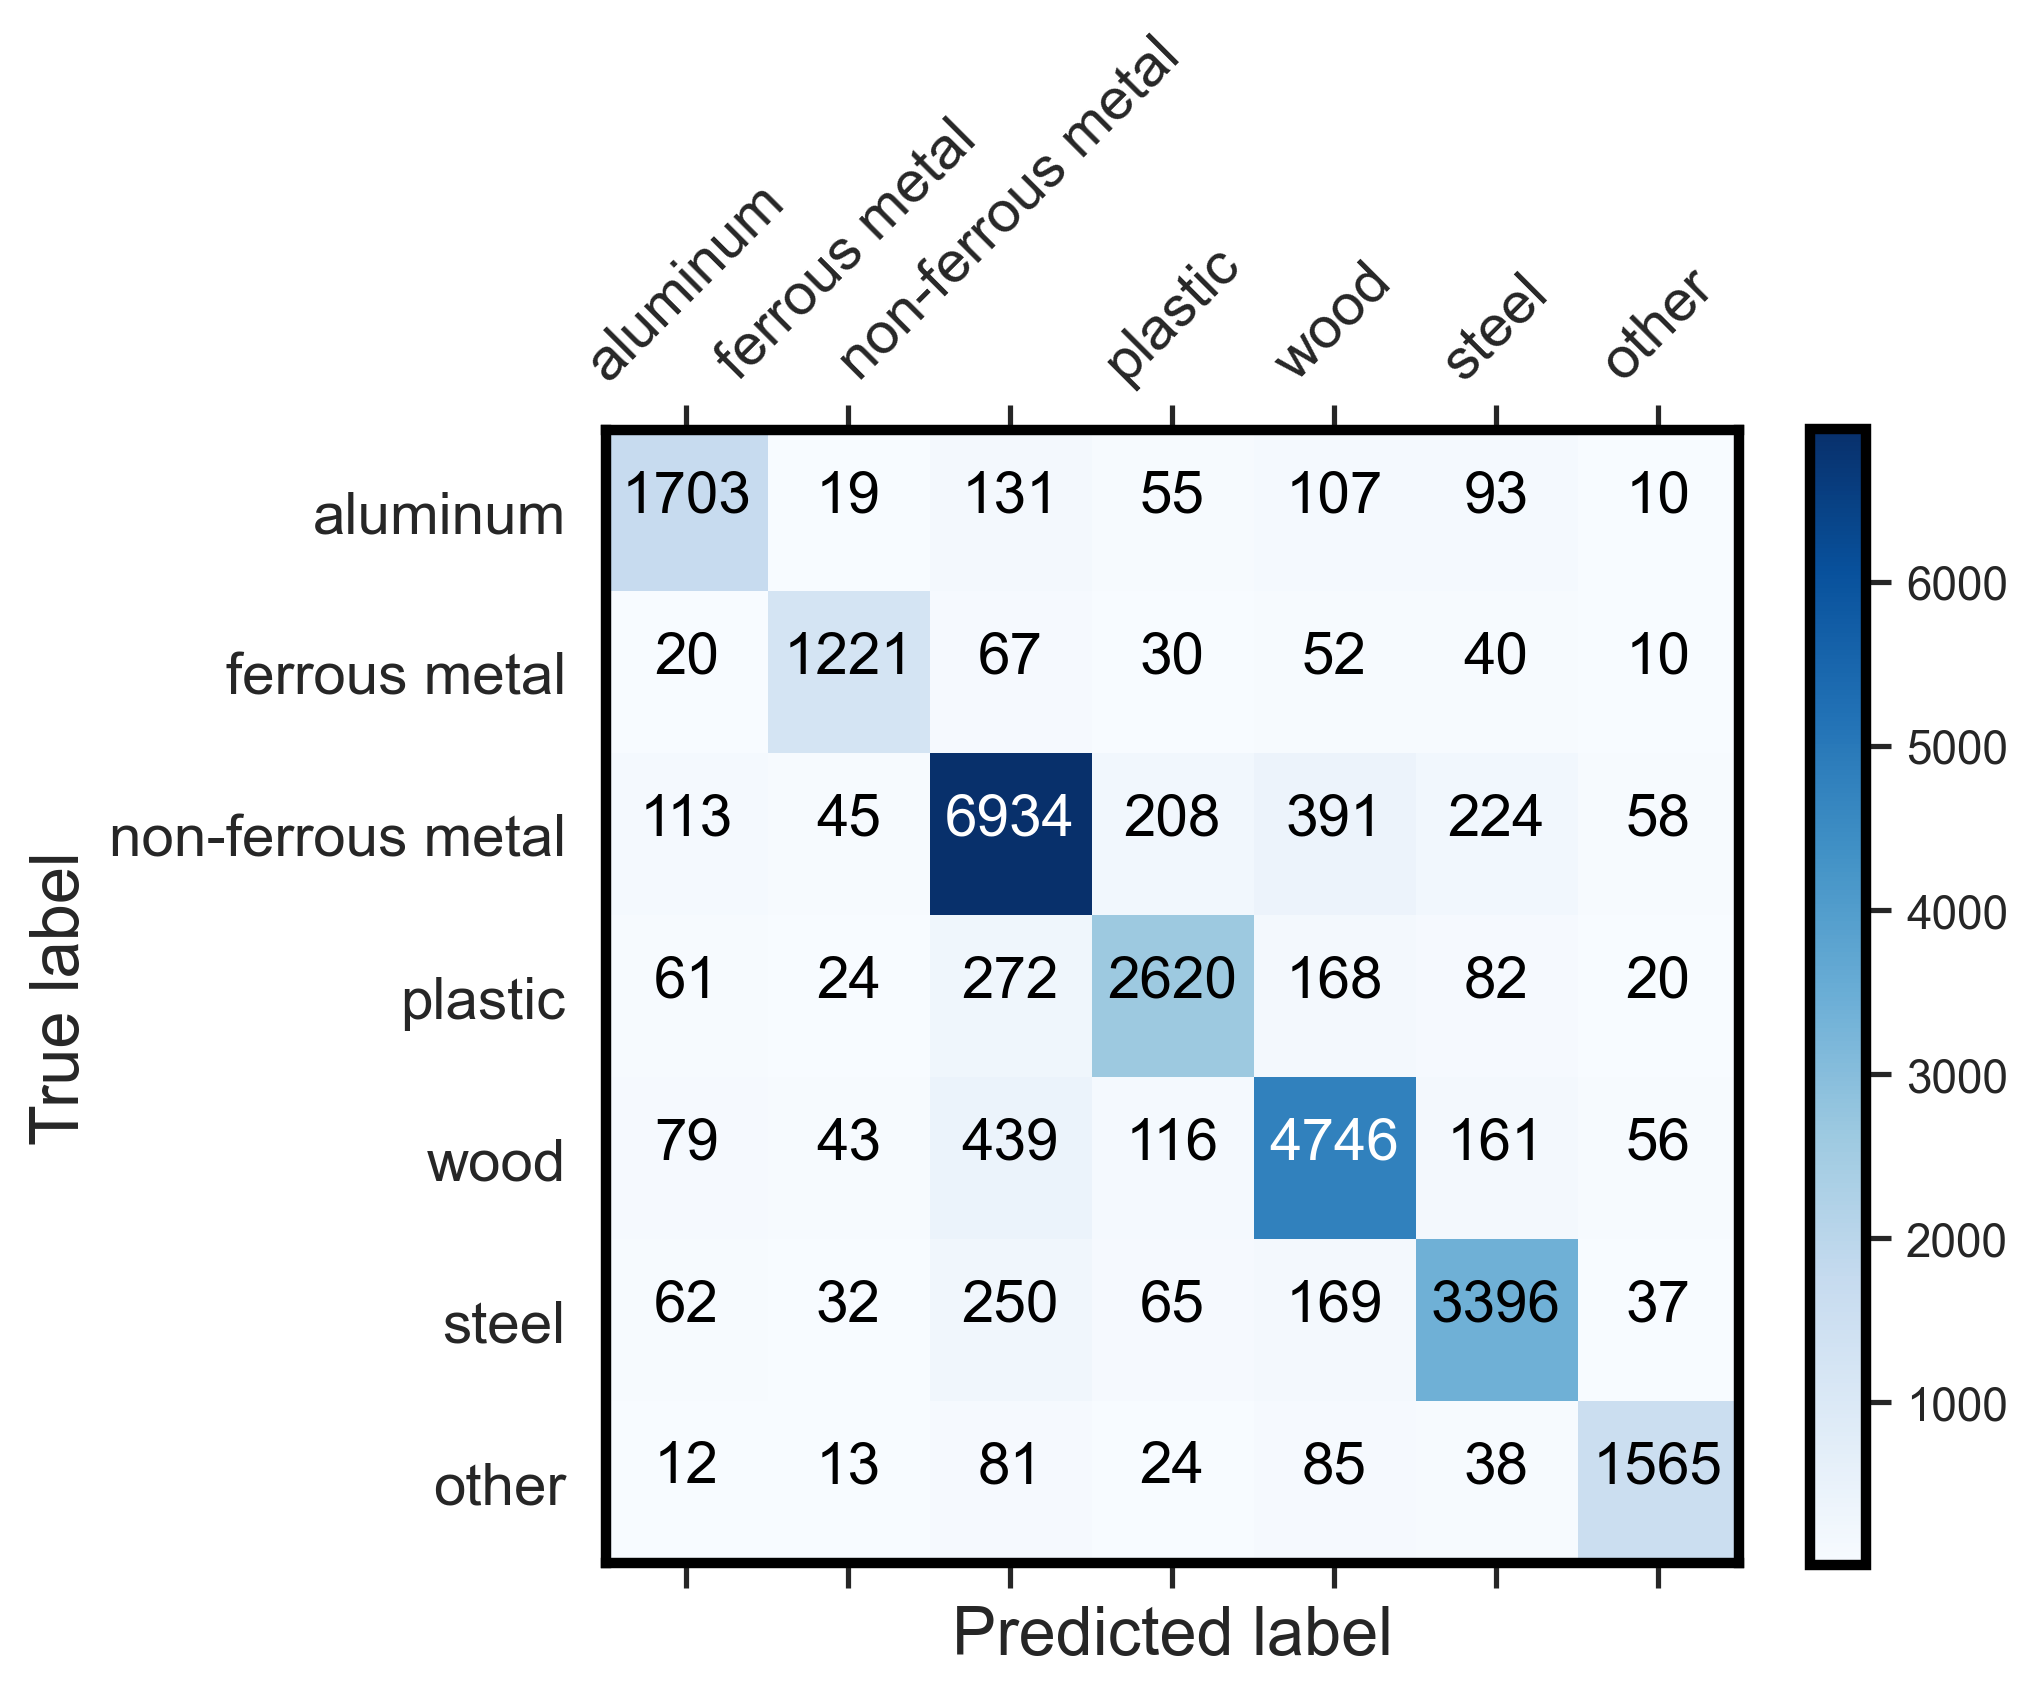

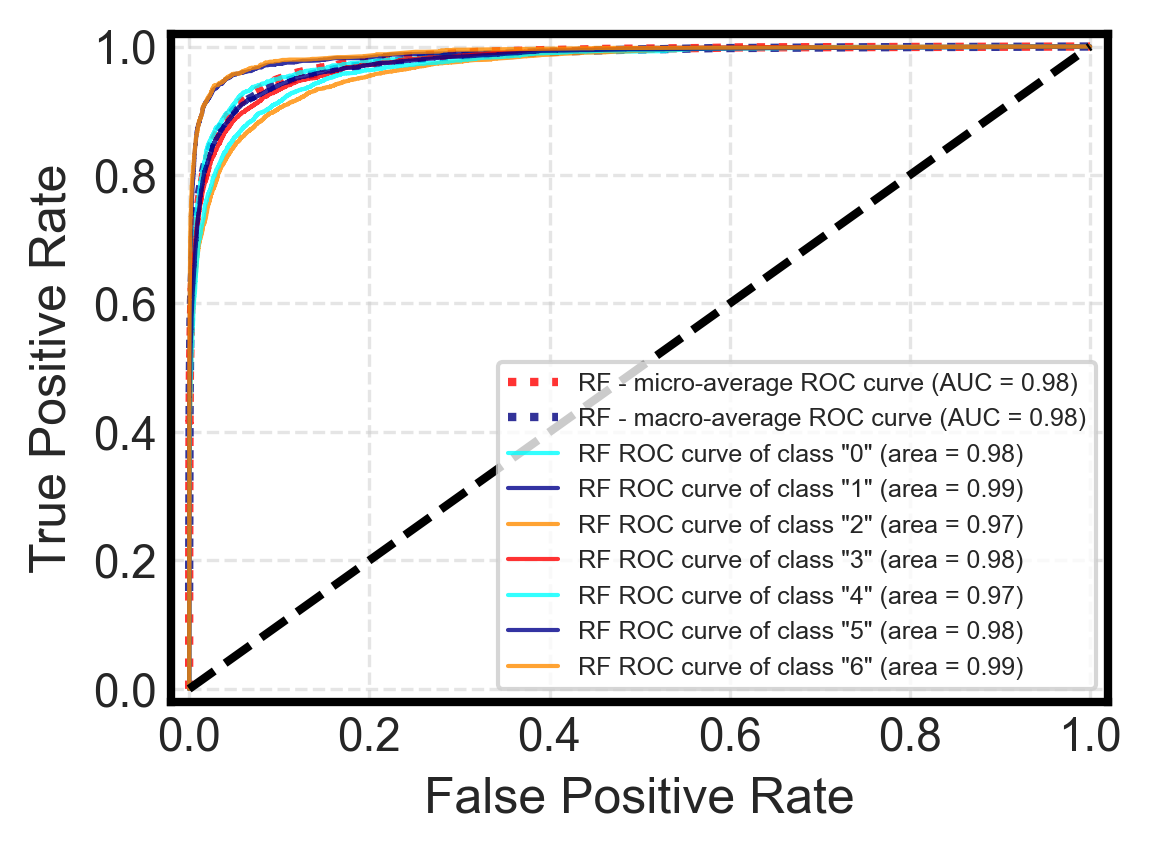

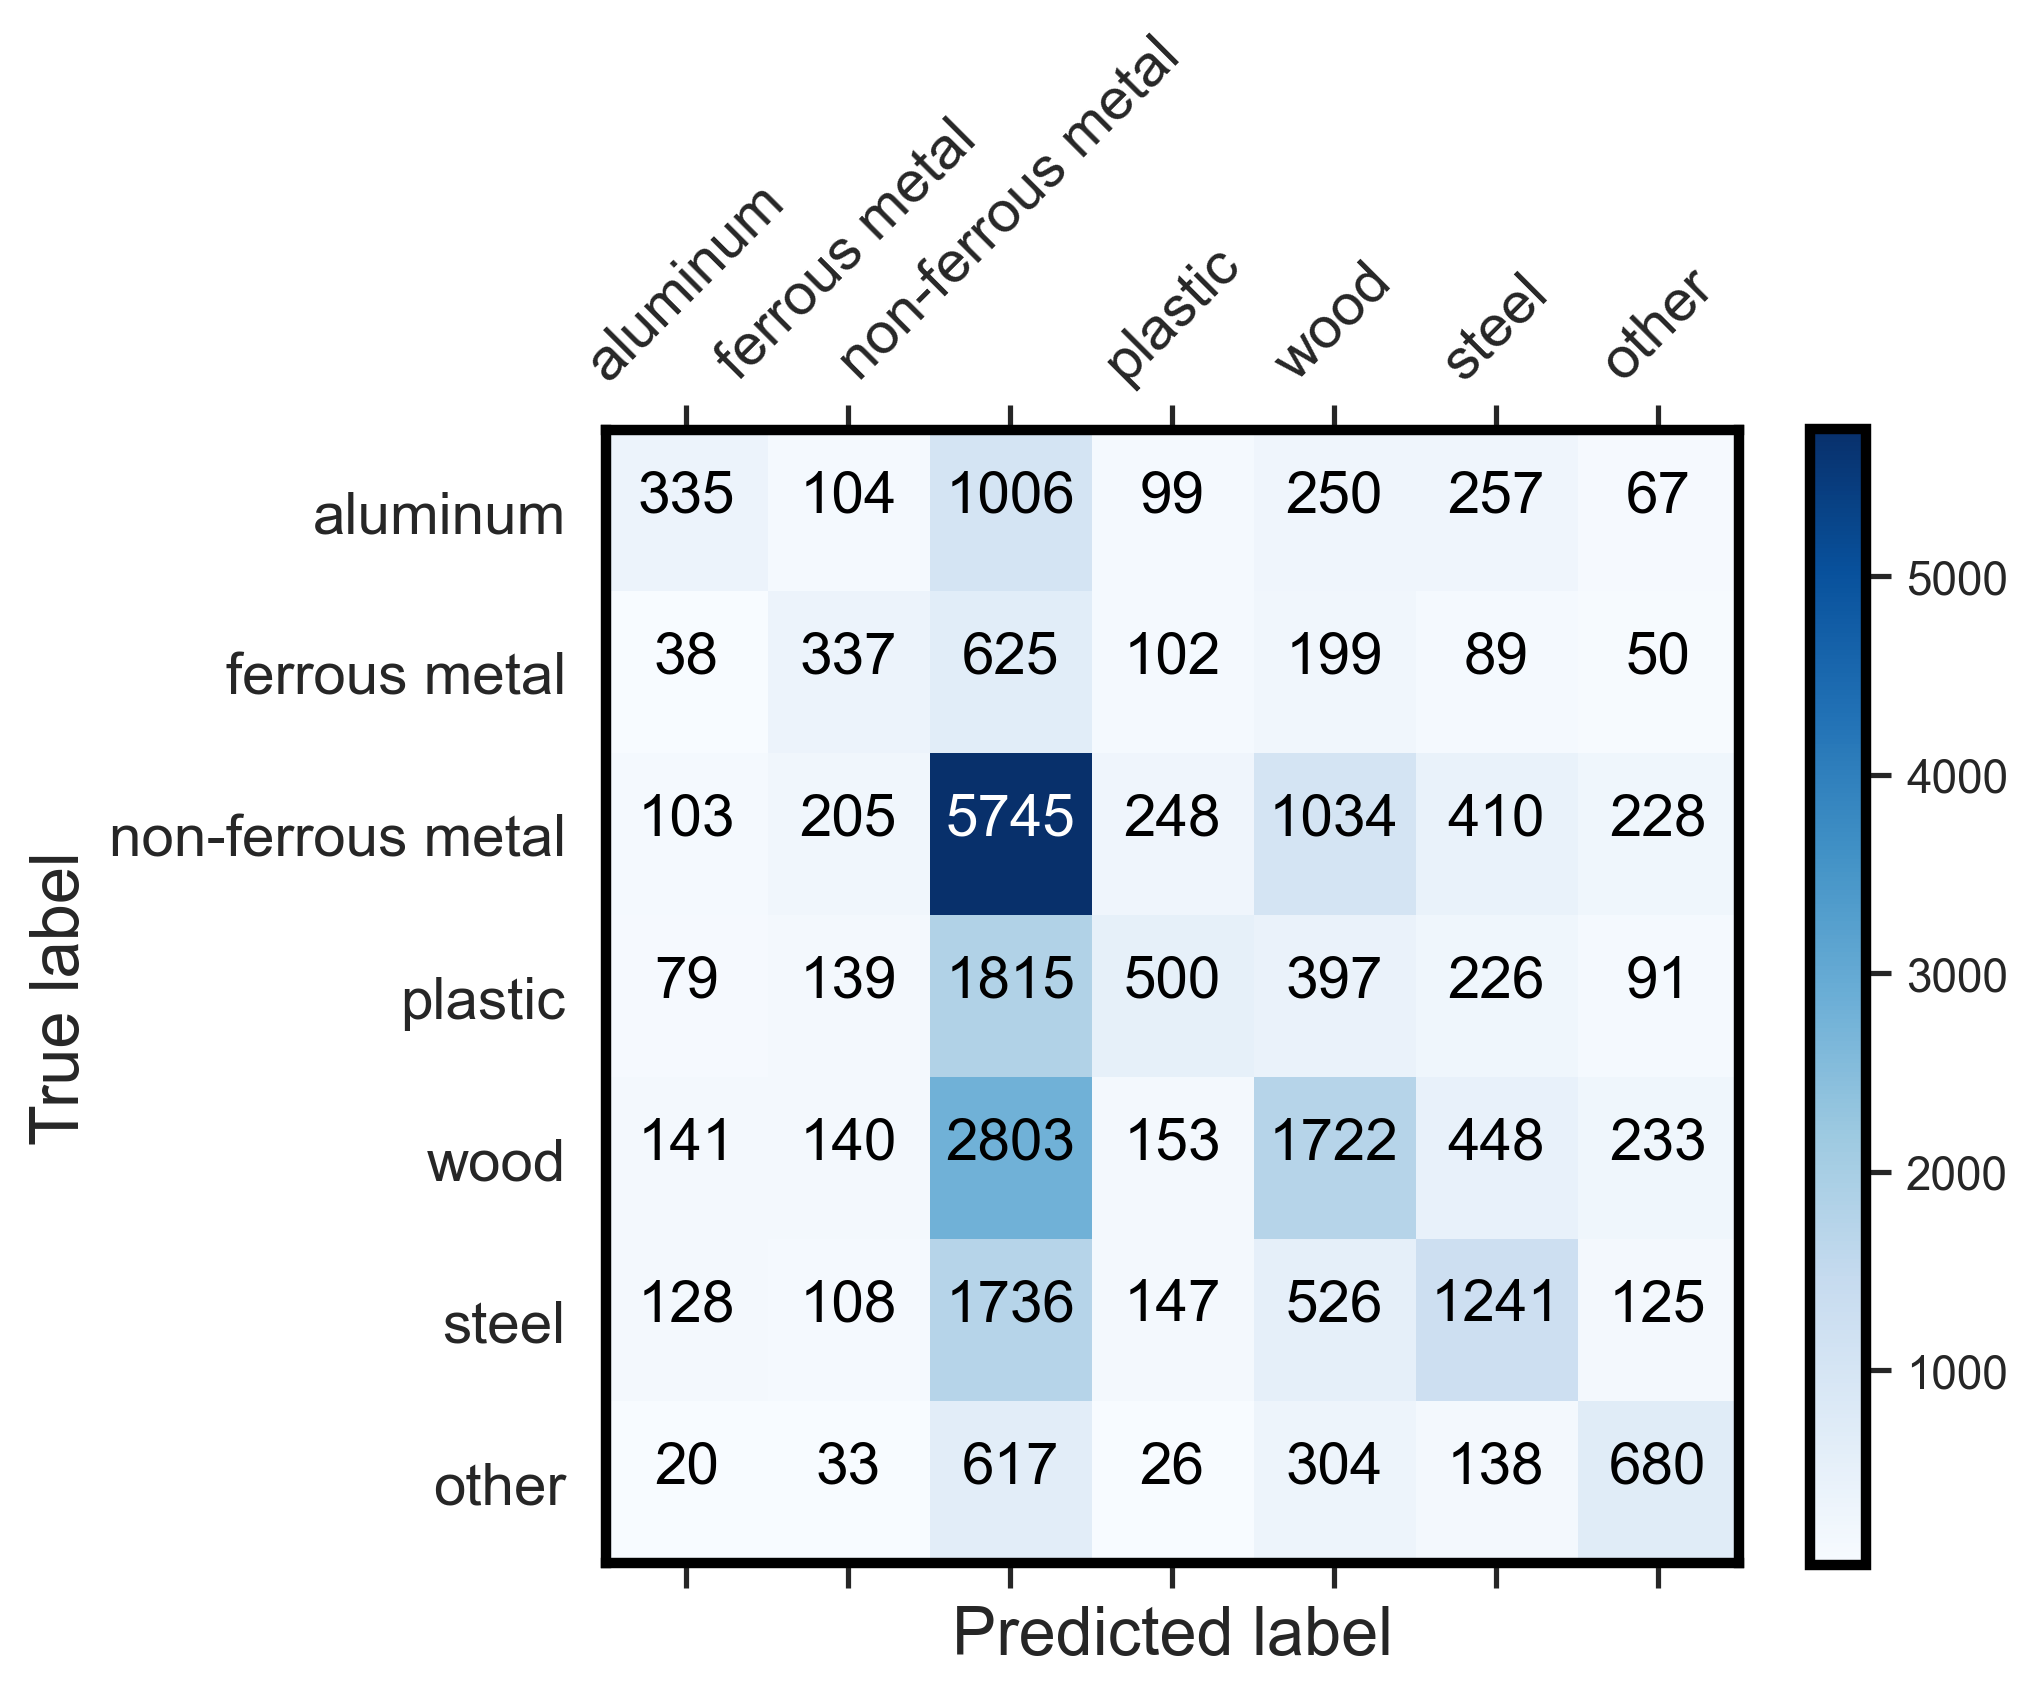

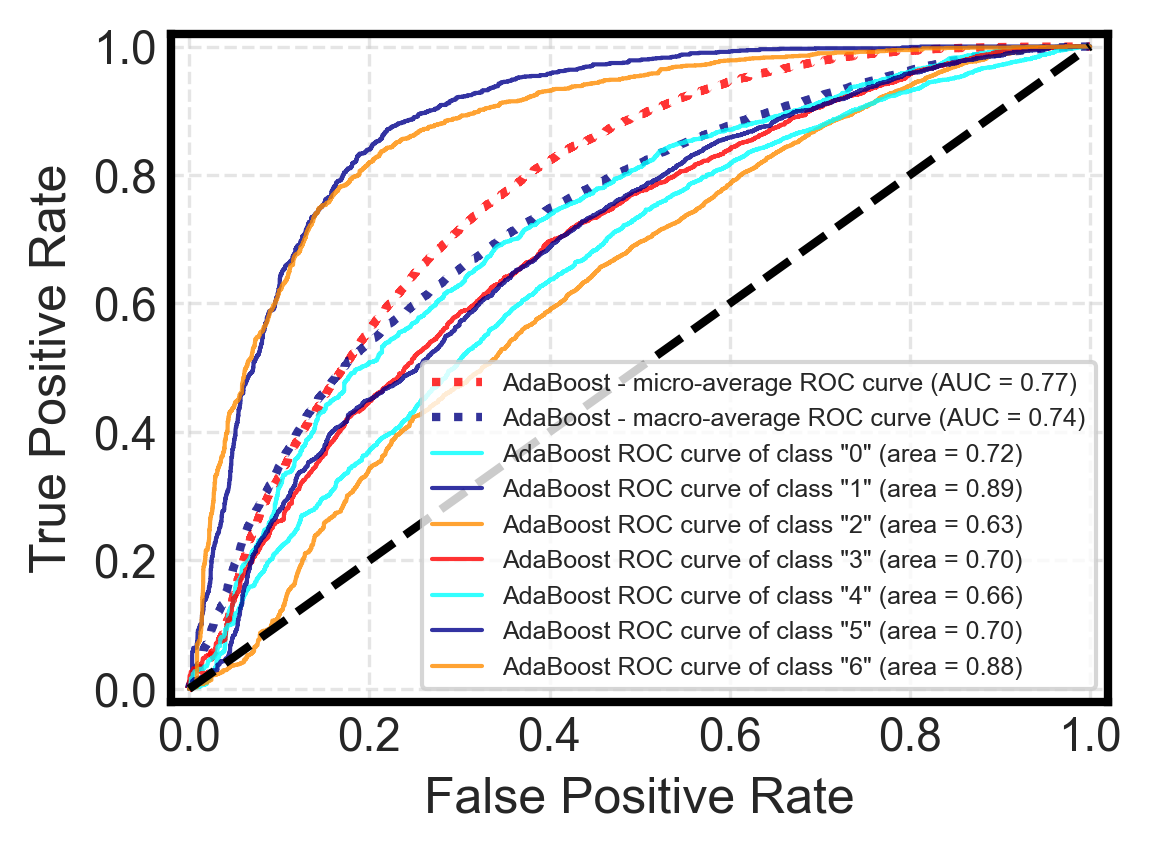

In [30]:
# Iterate over implemented models
for modeltoggle in ["KNN","DT", "LR","RF", "AdaBoost"]:  #,  "GPC", "GB", 'NN', "SVC"

    title = "Material Prediction "
    labels_categorical_= ['aluminum', 'ferrous metal', 'non-ferrous metal', 'plastic', 'wood', 'steel', 'other']
    labels_ = [0,1,2,3,4,5,6]
    n_classes = len(labels_)
    X = X_val_transformed
    Y = Y_val
    # One-hot-encode the ouput
    Y_test_ohe = label_binarize(Y, classes= [0,1,2,3,4,5,6])
    
    
    if modeltoggle == 'RF':
        model = rf_model
    elif modeltoggle == 'KNN':
        model = knn_model
    elif modeltoggle == 'AdaBoost':
        model = ada_model
    elif modeltoggle == 'DT':
        model = dt_model
    # elif modeltoggle == 'SVC':
    #     model = metamodel_SVC
    # elif modeltoggle == 'GB':
    #     model = metamodel_GB
    # elif modeltoggle == 'GPC':
    #     model = metamodel_GP
    # elif modeltoggle == 'NN':
    #     model = metamodel_NN
    elif modeltoggle == 'LR':
        model = lr_model
    # elif modeltoggle == 'NB':
    #     model = nb_model
    
    #################--------------------------------------------------------------------#####################
    ################--------------------------------- confusion matrix ------------------#####################
    ################---------------------------------------------------------------------#####################
    # for calculating the confusion matrix
    Y_predict = model.predict(X)
    # Category/ label that was wrongly classified by the model: View the class with WRONG classificaiton 
    pred_result = list(zip(Y, Y_predict))
    result_df = pd.DataFrame(pred_result, columns = ['label', 'pred_label'])
    result_df = result_df[result_df['label'] != result_df['pred_label']]
    
    print(classification_report(Y, Y_predict))
 
    show_confusion_matrix(Y, Y_predict, classes=labels_, classes_categorical=labels_categorical_,  normalize=None, 
                     figsize=(7,7), dpi=300, fontsize=14, axis_fontsize=16, tick_size=14)

    save_fig("confusion_matrix_basic_feature" + "_" + modeltoggle  )
    
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #################--------------------------------------------------------------------#####################
    ################------------ Testing performance on k-fold on the model -------------#####################
    ################---------------------------------------------------------------------#####################
    kf = KFold(n_splits=5)
    skf = StratifiedKFold(n_splits=5)
    trains = []
    tests = []
    
    
    # for train, test in kf.split(X):
    for train, test in skf.split(X, Y):

        X_shuffle, y_shuffle = shuffle(X, Y, random_state=0)
        y_shuffle = np.array(y_shuffle)

        # X_cv_train_before = X_shuffle[train]
        # X_cv_test_before = X_shuffle[test]
        X_train_cv = X_shuffle[train]
        X_test_cv = X_shuffle[test]
        y_train_cv = y_shuffle[train]
        y_test_cv = y_shuffle[test]
        # clf.fit(X_train_cv, y_train_cv)
        # trains.append(clf.score(X_train_cv, y_train_cv))
        tests.append(model.score(X_test_cv, y_test_cv))
    
    #################--------------------------------------------------------------------#####################
    ################--------------- AUC-ROC score measurement --------------------#####################
    ################---------------------------------------------------------------------#####################
    
    # ----------------Learn to predict each class against the other------------------------
    # classifier = OneVsRestClassifier(model)
    if modeltoggle == 'SVC':
        # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        y_score = model.decision_function(X)
    else:
        # y_score = classifier.fit(X_train, Y_train_ohe).predict_proba(X_test)
        y_score = model.predict_proba(X)
    
    # ---------------Compute ROC curve and ROC area for each class-------------------------
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_ohe.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ----------------------------------Plot all ROC curves-------------------------------
    plt.figure(figsize = (4,3), dpi = 300)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    
         
    #---------------------------(1) micro and macro ROC curve---------------------------
    plt.plot(fpr["micro"], tpr["micro"],
             label=modeltoggle + ' - micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='red', linestyle=':', linewidth=2, alpha = 0.8) #deeppink, midnightblue

    plt.plot(fpr["macro"], tpr["macro"],
             label=modeltoggle + ' - macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2, alpha = 0.8) #navy, gold
    
    #---------------------------(2) ROC curve for each class---------------------------
    colors = cycle(["aqua", "darkblue", "darkorange", "red"])
    # colors = cycle(['0.45', 'steelblue',  'olive', 'silver'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],tpr[i],color=color,
                 lw=1, alpha = 0.8,
                 label=modeltoggle + " ROC curve of class \"{0}\" (area = {1:0.2f})".format(labels_[i], roc_auc[i])) 
        
        

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.title("ROC curve")
    plt.legend(loc="lower right",  fontsize = '6', frameon = True, framealpha=0.8)
    # plt.show()
    plt.grid(linestyle='--', alpha=0.5, linewidth=0.8)
    
    #---------------------------------Aggregate information----------------------------------
 
    # trains = np.array(trains)
    tests = np.array(tests)

    test_accuracy_mean = tests.mean()
    test_accuracy_std = tests.std()
    # train_accuracy_mean = trains.mean()
    # train_accuracy_std =  trains.std()
    
    
    auc_score_list = []
    auc_score_list.append(auc(fpr["micro"], tpr["micro"]))
    
    auc_score_array = np.array(auc_score_list)
    auc_mean = auc_score_array.mean()
    auc_std = auc_score_array.std()
    
    
    # store into list
    auc_mean_list.append(auc_mean)
    auc_std_list.append(auc_std)
    accuracy_mean_list.append(test_accuracy_mean)
    accuracy_std_list.append(test_accuracy_std)
    
    print('Test Accuracy (cross-validation) for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(test_accuracy_mean, test_accuracy_std))
    print('micro-averaging AUC for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(auc_mean, auc_std))
    save_fig("ROC_" + modeltoggle + "_" + "basic_feature")

### Save trained model into folder

In [31]:
# Save Model Using Pickle
# ["KNN","DT", "LR", "SVC","GB", "RF" ]
# save the model to disk
metamodel_KNN_file = os.path.join(ML_model_PATH, 'metamodel_KNN.sav')
metamodel_DT_file = os.path.join(ML_model_PATH, 'metamodel_DT.sav')
metamodel_LR_file = os.path.join(ML_model_PATH, 'metamodel_LR.sav')
metamodel_ada_file = os.path.join(ML_model_PATH, 'metamodel_ada.sav')
# metamodel_SVC_file = os.path.join(ML_model_PATH, 'metamodel_SVC.sav')
# metamodel_GB_file = os.path.join(ML_model_PATH, 'metamodel_GB.sav')
metamodel_RF_file = os.path.join(ML_model_PATH, 'metamodel_RF.sav')
# metamodel_GP_file = os.path.join(ML_model_PATH, 'metamodel_GP.sav')
# metamodel_NN_file = os.path.join(ML_model_PATH, 'metamodel_NN.sav')

pickle.dump(knn_model, open(metamodel_KNN_file, 'wb'))
pickle.dump(dt_model, open(metamodel_DT_file, 'wb'))
pickle.dump(lr_model, open(metamodel_LR_file, 'wb'))
pickle.dump(ada_model, open(metamodel_ada_file, 'wb'))
# pickle.dump(metamodel_SVC, open(metamodel_SVC_file, 'wb'))
# pickle.dump(metamodel_GB, open(metamodel_GB_file, 'wb'))
pickle.dump(rf_model, open(metamodel_RF_file, 'wb'))
# pickle.dump(metamodel_GP, open(metamodel_GP_file, 'wb'))
# pickle.dump(metamodel_NN, open(metamodel_NN_file, 'wb'))

In [32]:
# load the model from disk
loaded_RF = pickle.load(open(metamodel_RF_file, 'rb'))
result = loaded_RF.score(X_val_transformed, Y_val)
print(result)

0.8452394559378215


## Model performance statistics

In [34]:
# Sample data
models =["KNN","DT", "LR","RF", "AdaBoost"]

Saving figure Accuracy-all


C:\Users\Asus\AppData\Local\Temp\ipykernel_30904\1972163146.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saving figure AUC-all


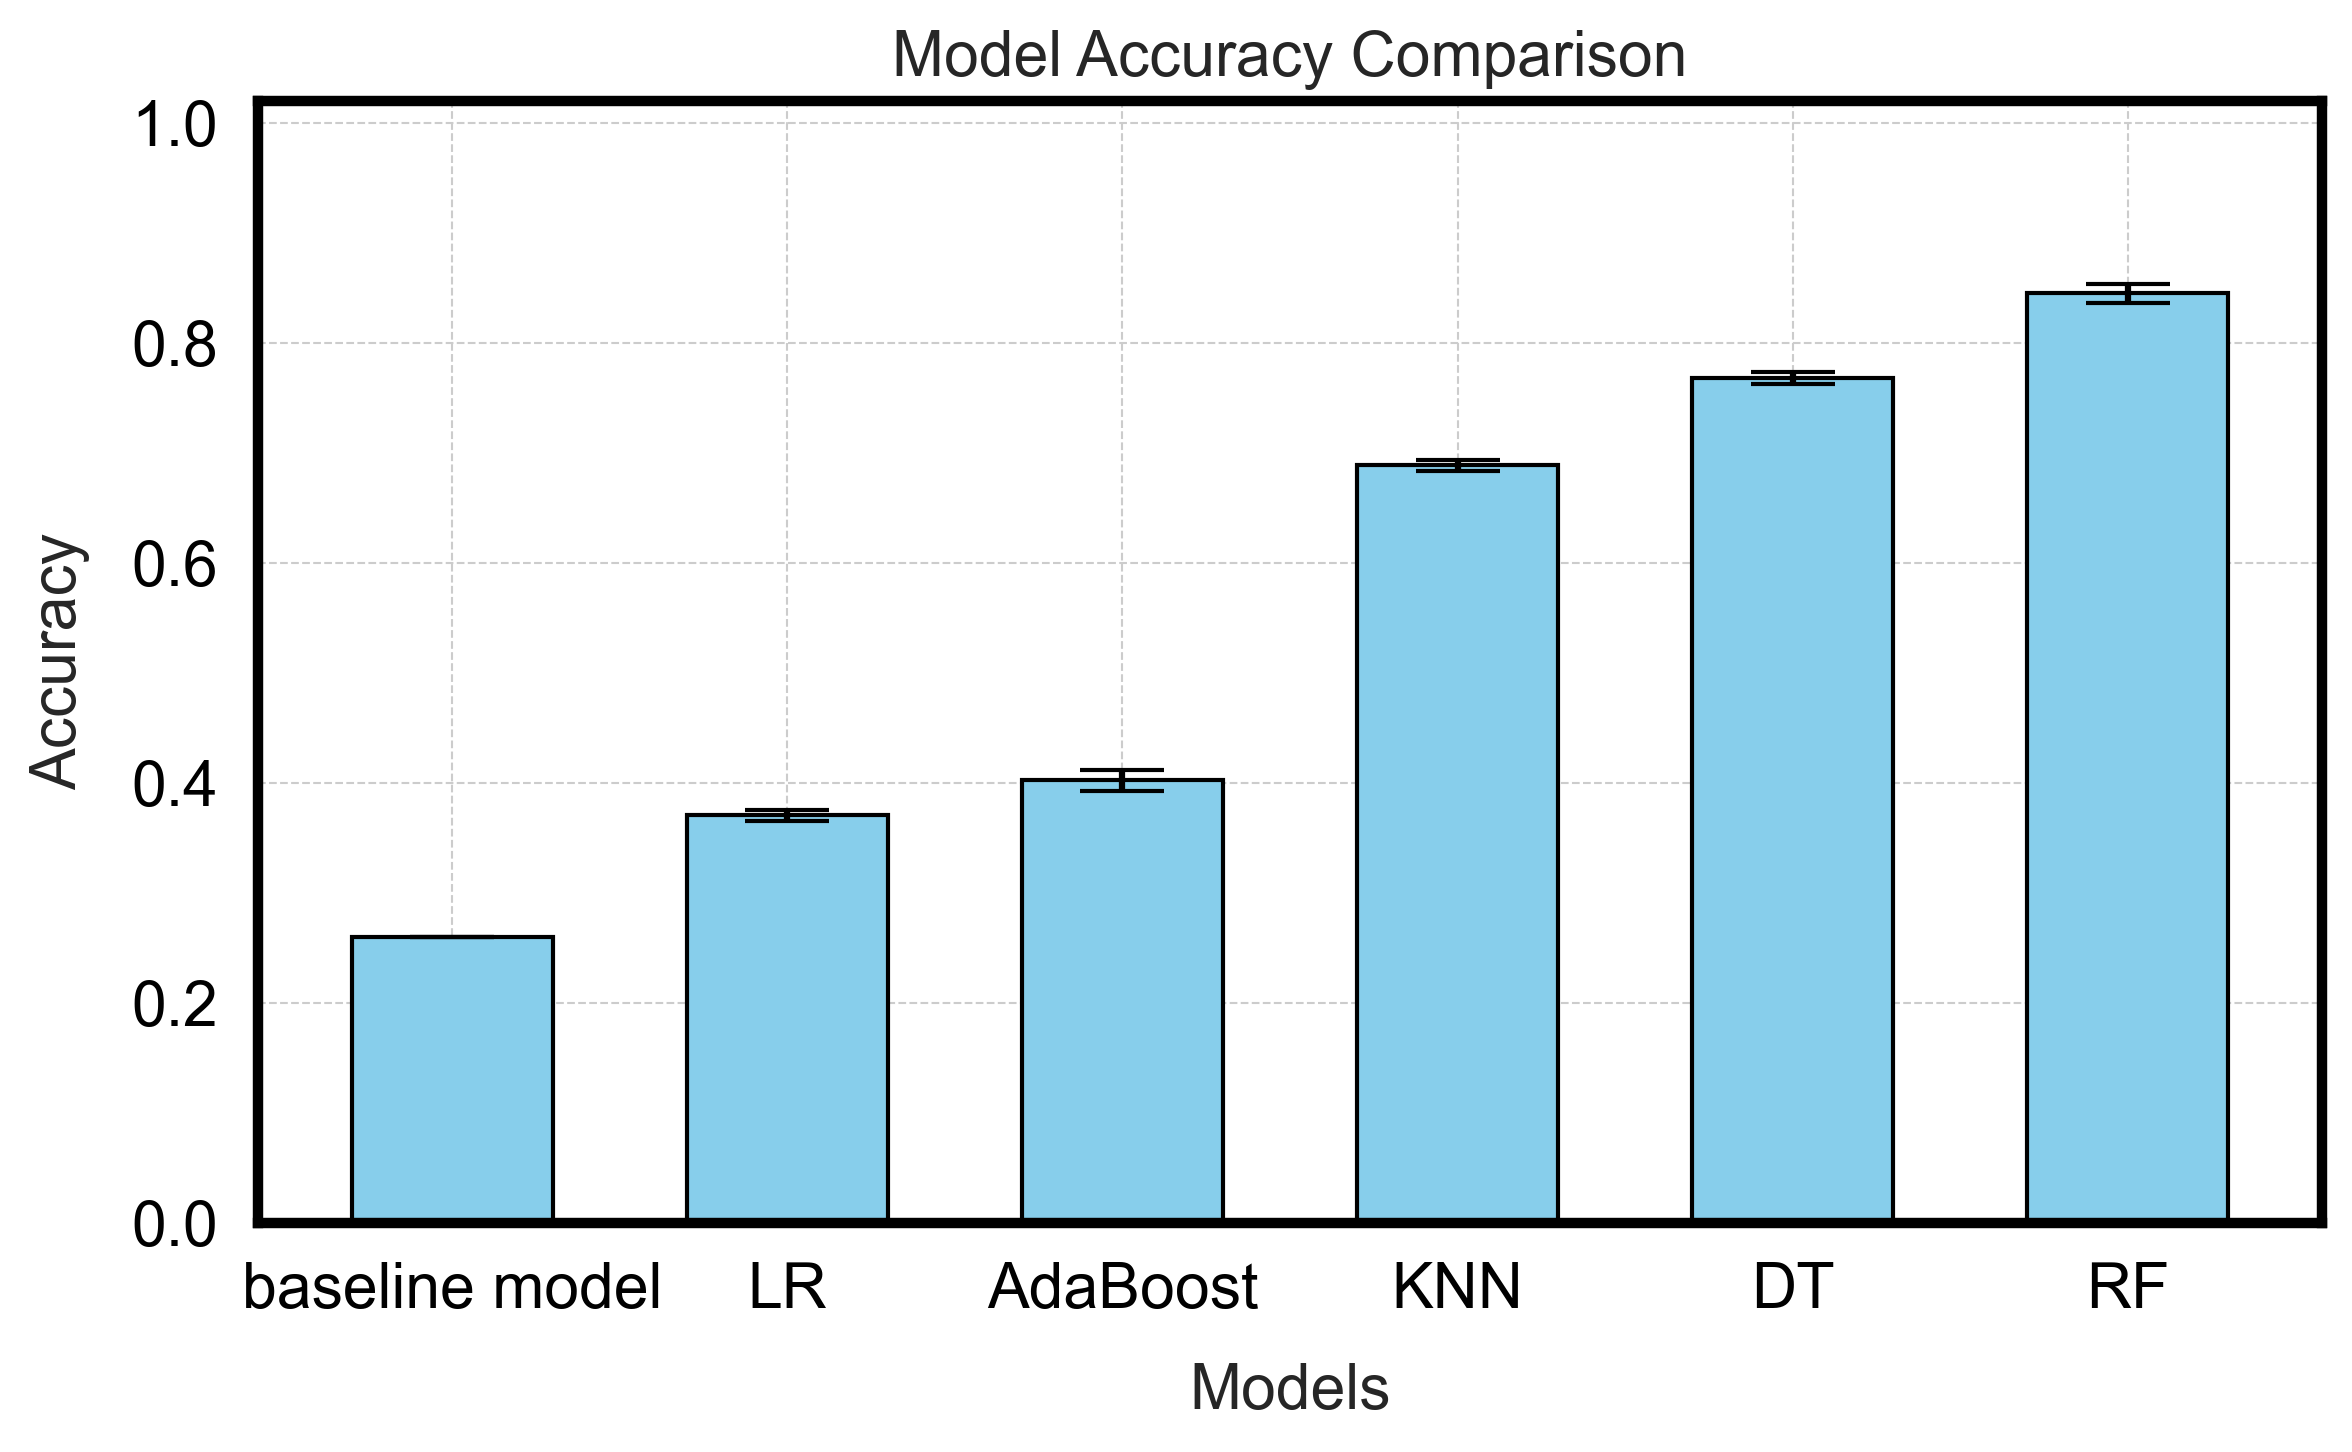

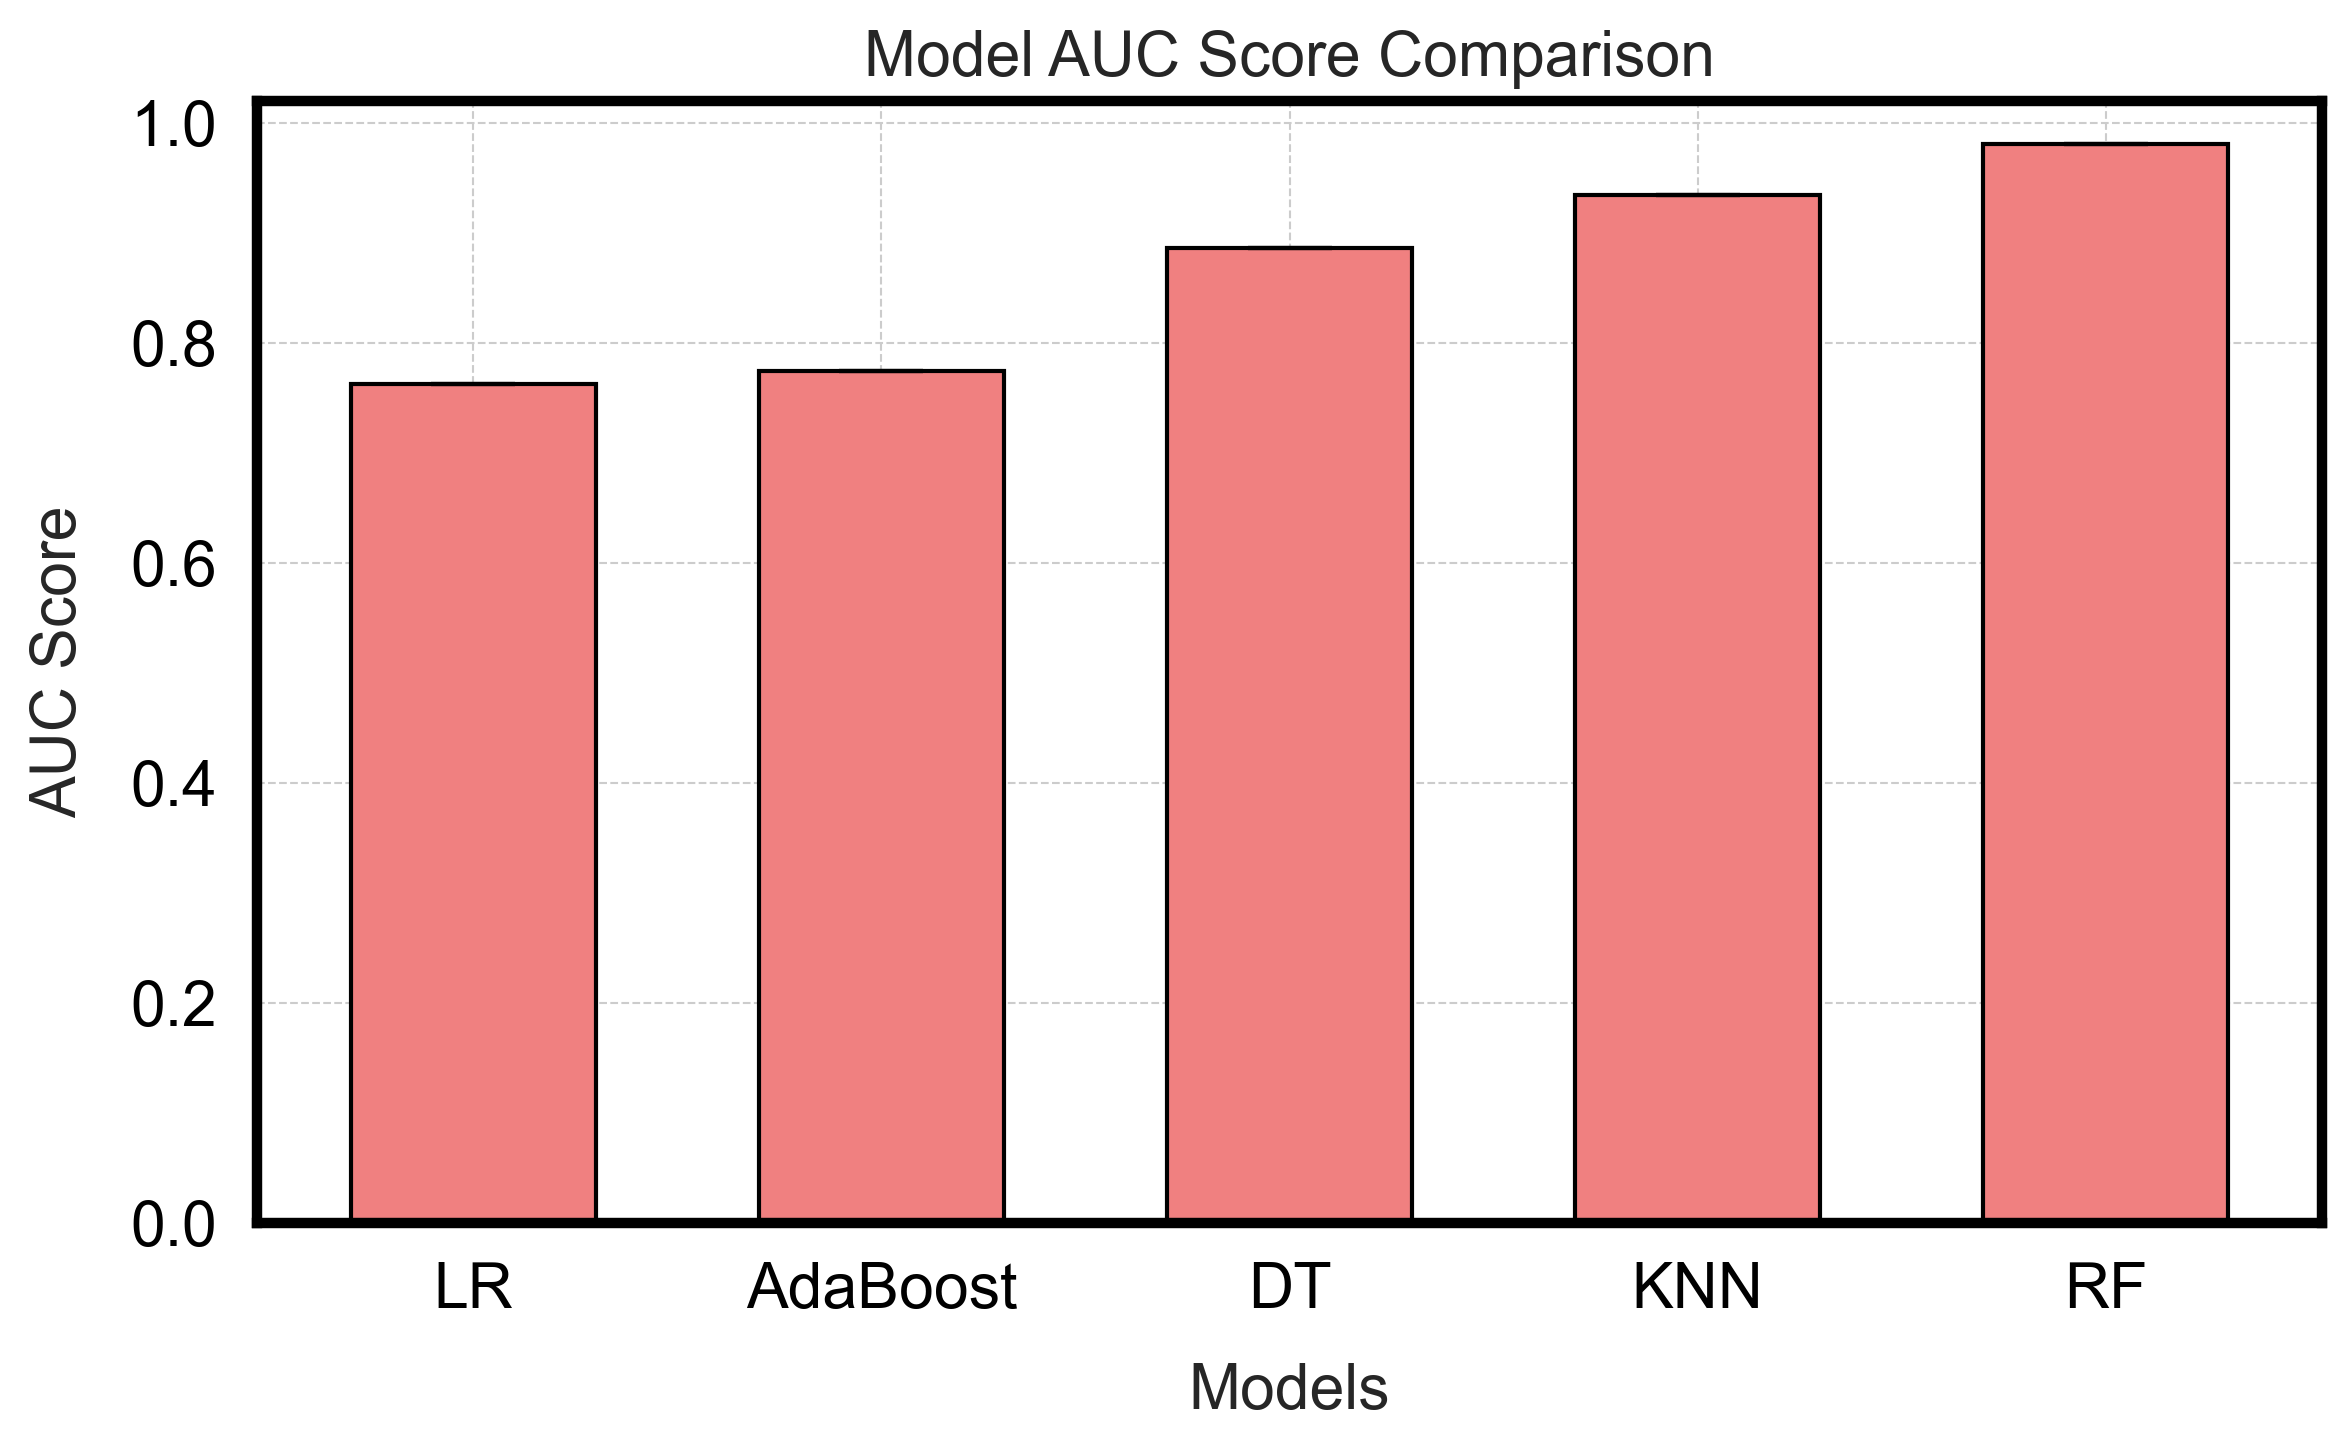

In [35]:
def plot_model_metrics(models, mean_list, std_list, metric_name, color, 
                       bar_width=0.6, edge_width=1, fontsize=15, 
                       labelpad=10, figsize=(8, 5), dpi=300, add_baseline=False):
    
    # If baseline model is to be added (only for accuracy)
    if add_baseline:
        models.append("baseline model")
        mean_list.append(0.26)
        std_list.append(0)
    
    # Sorting by mean values
    sorted_indices = np.argsort(mean_list)
    sorted_models = np.array(models)[sorted_indices]
    sorted_means = np.array(mean_list)[sorted_indices]
    sorted_stds = np.array(std_list)[sorted_indices]
    
    # Plotting
    plt.figure(figsize=figsize, dpi=dpi)
    plt.bar(sorted_models, sorted_means, yerr=sorted_stds, 
            capsize=10, color=color, width=bar_width, 
            edgecolor='black', linewidth=edge_width)
    
    plt.ylabel(metric_name, fontsize=fontsize, labelpad=labelpad)
    plt.title(f'Model {metric_name} Comparison', fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("Models", fontsize=fontsize, labelpad=labelpad)
    
    # Add dotted grid
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    
    # Show ticks outwards
    plt.tick_params(direction='out', length=6, width=2, colors='black')
    
    plt.tight_layout()
    plt.ylim([0, 1.02])
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # plt.show()

# Plotting Accuracy with improvements
plot_model_metrics(models.copy(), accuracy_mean_list.copy(), accuracy_std_list.copy(), 
                   "Accuracy", 'skyblue', add_baseline=True)
save_fig ("Accuracy-all")
# Plotting AUC with improvements
plot_model_metrics(models.copy(), auc_mean_list.copy(), auc_std_list.copy(), 
                   "AUC Score", 'lightcoral')
save_fig ("AUC-all")

In [36]:
accuracy_mean_list

[0.6887265601611192,
 0.7678594997686635,
 0.3704045505266309,
 0.8452395068448411,
 0.40233248963521395]

### Next Notebook: Make predictions on the test set, and save the results.